In [1]:
import scanpy as sc

/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/

In [2]:
adata_ctrl = sc.read_10x_mtx("/slurm/home/yrd/fanlab/gaomeng/NRI/1/sham")
adata_model = sc.read_10x_mtx("/slurm/home/yrd/fanlab/gaomeng/NRI/1/model")
adata_smi = sc.read_10x_mtx("/slurm/home/yrd/fanlab/gaomeng/NRI/1/smi")

In [3]:
import anndata as ad

# 设置样本信息
adata_ctrl.obs["sample"] = "ctrl"
adata_model.obs["sample"] = "model"
adata_smi.obs["sample"] = "smi"

# 解决 obs_names 可能的重复问题
adata_ctrl.obs_names = "ctrl_" + adata_ctrl.obs_names
adata_model.obs_names = "model_" + adata_model.obs_names
adata_smi.obs_names = "smi_" + adata_smi.obs_names

# 合并数据
adata = ad.concat([adata_ctrl, adata_model, adata_smi], axis=0, join="outer")

# 再次确保唯一性
adata.obs_names_make_unique()

# 检查合并后的样本信息
print(adata.obs["sample"].value_counts())


sample
model    14512
smi      13315
ctrl     12170
Name: count, dtype: int64


In [4]:
print(adata)


AnnData object with n_obs × n_vars = 39997 × 48945
    obs: 'sample'


In [5]:
import scanpy as sc
import numpy as np
# 计算质控指标
adata = adata.copy()  # 确保是实际对象而非 view
adata.var["mt"] = adata.var_names.str.startswith("MT-")  # 线粒体基因
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)


In [6]:
# 过滤低质量细胞
adata = adata[adata.obs["n_genes_by_counts"] > 200, :]  # 至少 200 个基因
adata = adata[adata.obs["total_counts"] < 50000, :]  # 过滤高 UMI 计数的细胞
adata = adata[adata.obs["pct_counts_mt"] < 5, :]  # 线粒体基因比例 < 5%

In [7]:
# 归一化（每个细胞标准化到 10,000 计数）
adata = adata.copy()  # 确保是实际对象而非 view
sc.pp.normalize_total(adata, target_sum=1e4)
# 对数变换
sc.pp.log1p(adata)

In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# 只保留高变基因
adata.raw=adata
adata = adata[:, adata.var.highly_variable]


/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [9]:
#降维
adata = adata.copy()  # 确保是实际对象
sc.pp.pca(adata, n_comps=50, svd_solver="arpack")  # 避免计算卡住

In [10]:
import numpy as np
# 将稀疏矩阵转换为稠密矩阵
import scipy.sparse as sp
 #确保 `adata.X` 不是一个 view
adata = adata.copy()
 #检查 `adata.X` 是否是稀疏矩阵，并强制转换为稠密矩阵
if sp.issparse(adata.X):  
    print("Converting sparse matrix to dense...")
    adata.X = adata.X.toarray()  # 使用 `.toarray()` 转换为 NumPy 数组
else:
    print("adata.X is already dense.")

Converting sparse matrix to dense...


In [11]:
import harmonypy as hm

adata_corrected = hm.run_harmony(adata.obsm["X_pca"], adata.obs, 'sample', theta=2)  # 按样本去批次

2025-11-11 18:56:03,539 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-11-11 18:56:13,550 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-11-11 18:56:13,899 - harmonypy - INFO - Iteration 1 of 10
2025-11-11 18:56:24,795 - harmonypy - INFO - Iteration 2 of 10
2025-11-11 18:56:35,446 - harmonypy - INFO - Iteration 3 of 10
2025-11-11 18:56:46,038 - harmonypy - INFO - Iteration 4 of 10
2025-11-11 18:56:56,625 - harmonypy - INFO - Iteration 5 of 10
2025-11-11 18:57:07,269 - harmonypy - INFO - Iteration 6 of 10
2025-11-11 18:57:15,941 - harmonypy - INFO - Converged after 6 iterations


In [12]:
adata.obsm['X_pca_harmony'] = adata_corrected.Z_corr.T  # 转置矩阵

In [13]:
print(adata.obsm['X_pca_harmony'].shape)  # 期待输出 (39830, n_components)

(39830, 50)


In [14]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_pca_harmony)


In [15]:
#umap
#sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, random_state=42, use_rep="X_pca_harmony")
#sc.tl.umap(adata)
#sc.pl.umap(adata, color=["sample"])

In [16]:
#adata.obsm["X_pca"] = adata.obsm["X_pca_harmony"]  # 让 Scanpy 识别校正后的 PCA
#sc.pl.pca(adata, color="sample")

In [17]:
#聚类
#sc.tl.leiden(adata, resolution=0.5,random_state=42)
#sc.pl.umap(adata, color=["leiden"], legend_loc="on data")

In [18]:
#genes_of_interest = ["Tnnt2", "Actc1", "Myh6", "Nppa","Col1a1", "Col3a1", "Postn", "Ddr2","Lum","Dcn","Pecam1", "Cdh5", "Vwf", "Tek","Acta2", "Myh11", "Tagln", "Cnn1","Pdgfrb", "Cspg4", "Rgs5", "Abcc9","Cd68","Cd14","Adgre1", "C1qa", "C1qb", "Cd74", "Irf8","Plac8", "Lyz2","Cd3d", "Cd3e", "Cd4", "Cd8a","Cd3d","Cd3e","Cd3g","Klrd1", "Cd8a","Cd19", "Cd79b", "Ms4a1", "Ighm","S100a8", "S100a9", "Cxcr2", "Camp","Lcn2","Tubb3", "S100b", "Nefl", "Syn1",'Ngfr']
#sc.pl.dotplot(adata, var_names=genes_of_interest, groupby='leiden')


In [19]:
# 添加cell_type列
#adata.obs["cell_type"] = adata.obs['leiden'].map(cluster_to_cell_type)

# 检查是否成功添加
#print(adata.obs["cell_type"].head())  # 检查 'cell_type' 列是否成功添加


In [20]:

# 保存 h5ad 文件（包含聚类和注释）
#adata.write("annotated_data.h5ad")


In [21]:
import pandas as pd
# 读取 celltype 注释
annots = pd.read_csv("sce_annotation.csv")
# 查看前几行确认格式
print(annots.head())

                    cell_id               celltype
0  model_AAACCCAAGAACCCGA-1            Fibroblasts
1  model_AAACCCAAGTAGTCTC-1  Natural killing cells
2  model_AAACCCACAAACACCT-1            Fibroblasts
3  model_AAACCCACAATCTCTT-1      Endothelial cells
4  model_AAACCCACAGACACAG-1            Neutrophils


In [22]:

# 将所有以 'sham' 为前缀的 cell_id 替换为 'ctrl'
annots['cell_id'] = annots['cell_id'].str.replace('^sham', 'ctrl', regex=True)
# 提取 cell_id 中的前缀部分（假设前缀部分是 '-' 之前的字符串）
prefixes = annots['cell_id'].str.split('_', expand=True)[0]

# 查看前缀的唯一值
print(prefixes.unique())

['model' 'ctrl' 'smi']


In [23]:
# 设置 index 为细胞 ID
annots.set_index("cell_id", inplace=True)

# 确保 index 类型一致（字符串）
adata.obs.index = adata.obs.index.astype(str)
annots.index = annots.index.astype(str)
# 再从 annots 中选出与 adata.obs.index 对齐的行
common_cells = adata.obs.index.intersection(annots.index)

# 添加注释信息（只在匹配到的细胞中）
adata.obs.loc[common_cells, 'celltype'] = annots.loc[common_cells, 'celltype']

In [24]:
print(f"adata 中共有 {adata.n_obs} 个细胞")
print(f"注释文件中有 {annots.shape[0]} 个细胞注释")
print(f"成功匹配到注释的细胞数：{len(common_cells)}")

adata 中共有 39830 个细胞
注释文件中有 34470 个细胞注释
成功匹配到注释的细胞数：34465


In [25]:
# 获取注释文件中的细胞 ID（索引）
matching_cells = annots.index

# 只保留匹配到的细胞
matched_cells = adata.obs.index.intersection(matching_cells)

# 根据匹配的细胞 ID 筛选 adata
adata = adata[matched_cells, :]

In [26]:
print(f"adata 中共有 {adata.n_obs} 个细胞")
print(f"注释文件中有 {annots.shape[0]} 个细胞注释")
print(f"成功匹配到注释的细胞数：{len(common_cells)}")

adata 中共有 34465 个细胞
注释文件中有 34470 个细胞注释
成功匹配到注释的细胞数：34465


In [27]:
# 重命名 'celltype' 为 'cell_type'
adata.obs.rename(columns={'celltype': 'cell_type'}, inplace=True)
# 查看注释是否还在
print(adata.obs['cell_type'].value_counts())

cell_type
Endothelial cells        13005
Fibroblasts              10386
Monocytes                 2656
Macrophages               2140
Neutrophils               1939
Pericytes                 1411
Smooth muscle cells        732
T cells                    614
Dendritic cells            600
Natural killing cells      445
B cells                    294
Schwann cells              243
Name: count, dtype: int64


/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


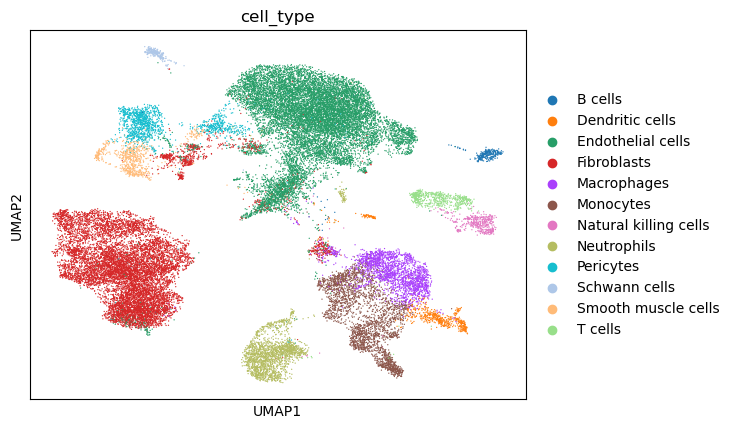

In [28]:
# 使用 'cell_type' 作为颜色来查看手动注释后的 UMAP
# 使用默认设置绘制 UMAP 图
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, random_state=42, use_rep="X_pca_harmony")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["cell_type"],legend_loc="right margin",save="_celltype.pdf")


In [29]:
# 过滤出ctrl组和model组的数据
adata_ctrl = adata[adata.obs['sample'] == 'ctrl', :].copy()
adata_model = adata[adata.obs['sample'] == 'model', :].copy()

# 获取ctrl组中的细胞类型
cell_types_ctrl = adata_ctrl.obs['cell_type'].unique()
print("Ctrl组中的细胞类型有：")
print(cell_types_ctrl)

# 获取model组中的细胞类型
cell_types_model = adata_model.obs['cell_type'].unique()
print("Model组中的细胞类型有：")
print(cell_types_model)


Ctrl组中的细胞类型有：
['Smooth muscle cells', 'Endothelial cells', 'Macrophages', 'Fibroblasts', 'T cells', ..., 'Dendritic cells', 'Pericytes', 'Natural killing cells', 'Schwann cells', 'Monocytes']
Length: 12
Categories (12, object): ['B cells', 'Dendritic cells', 'Endothelial cells', 'Fibroblasts', ..., 'Pericytes', 'Schwann cells', 'Smooth muscle cells', 'T cells']
Model组中的细胞类型有：
['Fibroblasts', 'Natural killing cells', 'Endothelial cells', 'Neutrophils', 'Pericytes', ..., 'Monocytes', 'B cells', 'Dendritic cells', 'T cells', 'Schwann cells']
Length: 12
Categories (12, object): ['B cells', 'Dendritic cells', 'Endothelial cells', 'Fibroblasts', ..., 'Pericytes', 'Schwann cells', 'Smooth muscle cells', 'T cells']


In [30]:
import numpy as np
import pandas as pd
import scipy.stats as stats
# 只保留 ctrl 和 model 组的数据并确保是副本
adata_filtered = adata[adata.obs['sample'].isin(['ctrl', 'model']), :].copy()

# 初始化一个字典存储每个细胞类型中每个基因的表达数据
cell_types = adata_filtered.obs['cell_type'].unique()  # 假设有 'cell_type' 列
fold_changes = {}
log2_model_expr = {}
# 遍历每个细胞类型
for cell_type in cell_types:
    # 获取该细胞类型在 ctrl 和 model 组的表达数据
    ctrl_cells = adata_filtered[(adata_filtered.obs['sample'] == 'ctrl') & 
                                 (adata_filtered.obs['cell_type'] == cell_type), :].X
    model_cells = adata_filtered[(adata_filtered.obs['sample'] == 'model') & 
                                  (adata_filtered.obs['cell_type'] == cell_type), :].X
    
    # 计算每个细胞类型在 ctrl 和 model 组中的平均表达
    ctrl_mean = np.mean(ctrl_cells, axis=0) + 1  # 加1避免 log(0)
    model_mean = np.mean(model_cells, axis=0) + 1  # 加1避免 log(0)
    # 计算 model 组每个基因的平均表达
    log2_model = np.log2(model_mean)  # 加1以避免 log(0)
    # 计算 fold change（log2）
    log2_fc = np.log2(model_mean / ctrl_mean)
    # 将结果保存到字典
    fold_changes[cell_type] = log2_fc
    log2_model_expr[cell_type] = log2_model

# 创建一个 DataFrame 保存所有细胞类型的 fold change
log2_fc_df = pd.DataFrame(fold_changes, index=adata_filtered.var_names)
log2_fc_df['gene'] = log2_fc_df.index  # 保持基因名
log2_fc_df = log2_fc_df[['gene'] + list(cell_types)]  # 调整列顺序

# 创建 DataFrame 保存 model 组基因表达的 log2 值
log2_model_expr_df = pd.DataFrame(log2_model_expr, index=adata_filtered.var_names) 
log2_model_expr_df['gene'] = log2_model_expr_df.index  # 保持基因名
log2_model_expr_df = log2_model_expr_df[['gene'] + list(cell_types)]  # 调整列顺序

# 创建一个 DataFrame 存储 change 信息
# 移除 'gene' 列，仅保留 log2 fold change 数值(创建log2_fc_values副本只保存数值）
log2_fc_values = log2_fc_df.set_index('gene')  # 确保基因名作为索引
log2_fc_values = log2_fc_values.apply(pd.to_numeric, errors='coerce')  # 转换为浮点数，确保计算无误

log2_fc_change_df = log2_fc_values.copy()
log2_fc_change_df = log2_fc_change_df.applymap(lambda x: 'up' if x > 0.5 else ('down' if x < -0.5 else 'stable'))
# 重新添加基因名列
log2_fc_change_df.insert(0, 'gene', log2_fc_values.index)
# 显示前几行
log2_fc_change_df.head()

/tmp/ipykernel_97657/4126282223.py:46: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  log2_fc_change_df = log2_fc_change_df.applymap(lambda x: 'up' if x > 0.5 else ('down' if x < -0.5 else 'stable'))


,gene,Smooth muscle cells,Endothelial cells,Macrophages,Fibroblasts,T cells,Neutrophils,B cells,Dendritic cells,Pericytes,Natural killing cells,Schwann cells,Monocytes
gene,,,,,,,,,,,,,
6430548M08Rikl,6430548M08Rikl,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable
AABR07000398.1,AABR07000398.1,up,up,up,up,up,up,up,up,up,up,up,up
AABR07000658.2,AABR07000658.2,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable,stable
AABR07001382.1,AABR07001382.1,up,up,up,up,up,up,stable,up,up,up,stable,stable
AABR07002700.1,AABR07002700.1,stable,stable,stable,stable,stable,stable,up,stable,stable,stable,stable,stable


In [31]:
# 查看最终结果
log2_fc_df

,gene,Smooth muscle cells,Endothelial cells,Macrophages,Fibroblasts,T cells,Neutrophils,B cells,Dendritic cells,Pericytes,Natural killing cells,Schwann cells,Monocytes
6430548M08Rikl,6430548M08Rikl,-0.054317,-0.179739,-0.037711,-0.093548,-0.020127,-0.486451,-0.017729,-0.026744,-0.055285,-0.036214,-0.032579,-0.324317
AABR07000398.1,AABR07000398.1,0.862590,0.925349,0.803873,0.826687,0.778754,0.660881,0.815344,0.672990,0.911079,0.827281,0.820246,0.695776
AABR07000658.2,AABR07000658.2,0.017649,0.212156,0.208085,0.125367,0.035871,0.012155,0.100048,0.017404,0.067119,0.250632,0.112835,0.044343
AABR07001382.1,AABR07001382.1,0.985346,1.141578,0.783626,0.776497,0.507520,0.513542,0.462773,0.585042,0.931305,0.745617,0.462326,0.433765
AABR07002700.1,AABR07002700.1,0.015238,0.010767,0.004231,0.008681,0.044736,0.000000,1.324396,0.049008,0.007983,0.018932,0.000000,0.011577
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zswim3,Zswim3,-0.007187,-0.003166,-0.035212,-0.056570,-0.013170,-0.045296,-0.130962,-0.028313,-0.019443,0.046688,-0.050904,-0.010234
Zswim4,Zswim4,0.109122,0.095402,-0.185062,-0.095407,-0.016093,0.036222,-0.060414,-0.144940,0.036148,0.095575,-0.050059,0.104588
Zswim5,Zswim5,-0.045348,0.027618,-0.008301,0.000505,-0.118807,0.018545,0.024186,0.025817,0.002911,0.053597,-0.130967,-0.030965
Zswim9,Zswim9,-0.003668,-0.014771,0.017893,-0.023267,-0.016194,0.022586,-0.047892,-0.021383,-0.009148,-0.007375,-0.030620,-0.009227


In [32]:
# 将 log2_fc_df 和 log2_model_expr_df 中的所有数据转换为数值类型
log2_fc_df = log2_fc_df.apply(pd.to_numeric, errors='coerce')
log2_model_expr_df = log2_model_expr_df.apply(pd.to_numeric, errors='coerce')

# 初始化一个字典来存储每个细胞类型符合条件的基因名称
filtered_genes_by_cell_type = {}

# 获取细胞类型列表
cell_types = log2_fc_df.columns

# 遍历每个细胞类型
for cell_type in cell_types:
    # 筛选出 log2_model > 0.8 的基因
    filtered_model_genes = log2_model_expr_df[cell_type][log2_model_expr_df[cell_type] > 0.65].dropna().index
    
    # 筛选出 log2_fc > 0.2 的基因
    filtered_fc_genes = log2_fc_df[cell_type][log2_fc_df[cell_type].abs() > 0.15].dropna().index
    
    # 获取两个条件都符合的基因名称（交集部分）
    common_genes = filtered_model_genes.intersection(filtered_fc_genes)
    
    # 保存符合条件的基因名称
    filtered_genes_by_cell_type[cell_type] = common_genes

# 统计每个细胞类型符合条件的基因数量
gene_counts_by_cell_type = {cell_type: len(genes) for cell_type, genes in filtered_genes_by_cell_type.items()}

# 打印每个细胞类型及其对应的基因数量
for cell_type, count in gene_counts_by_cell_type.items():
    print(f"{cell_type}: {count} genes")


gene: 0 genes
Smooth muscle cells: 140 genes
Endothelial cells: 135 genes
Macrophages: 180 genes
Fibroblasts: 162 genes
T cells: 149 genes
Neutrophils: 178 genes
B cells: 105 genes
Dendritic cells: 160 genes
Pericytes: 169 genes
Natural killing cells: 124 genes
Schwann cells: 150 genes
Monocytes: 220 genes


In [33]:
# 将字典转换为长表 DataFrame
records = []
for cell_type, gene_list in filtered_genes_by_cell_type.items():
    # 排除非细胞类型（例如 'gene'）
    if cell_type not in log2_fc_df.columns:
        continue
    for gene in gene_list:
        records.append({'cell_type': cell_type, 'gene': gene})

filtered_genes_df = pd.DataFrame(records)

# 显示前几行
print(filtered_genes_df.head())
print(filtered_genes_df.shape)

             cell_type            gene
0  Smooth muscle cells  AABR07000398.1
1  Smooth muscle cells  AABR07001382.1
2  Smooth muscle cells  AABR07025295.1
3  Smooth muscle cells  AABR07026012.1
4  Smooth muscle cells  AABR07026311.1
(1872, 2)


In [34]:
# ✅ 如果 gene 已经是 index，就不需要再设置 index
log2_fc_df_indexed = log2_fc_df.copy()

# 计算 log2_fc（使用行列定位）
def get_log2_fc(row):
    try:
        return log2_fc_df_indexed.loc[row['gene'], row['cell_type']]
    except KeyError:
        return None

# 填充 log2_fc
filtered_genes_df['log2_fc'] = filtered_genes_df.apply(get_log2_fc, axis=1)

# 检查结果
print(filtered_genes_df)


                cell_type            gene   log2_fc
0     Smooth muscle cells  AABR07000398.1  0.862590
1     Smooth muscle cells  AABR07001382.1  0.985346
2     Smooth muscle cells  AABR07025295.1  0.740180
3     Smooth muscle cells  AABR07026012.1  0.668051
4     Smooth muscle cells  AABR07026311.1  0.978159
...                   ...             ...       ...
1867            Monocytes            Tspo  0.301802
1868            Monocytes            Uap1  0.213204
1869            Monocytes             Ubb  1.842499
1870            Monocytes            Upp1  0.459351
1871            Monocytes            Vcan  0.800376

[1872 rows x 3 columns]


In [35]:
 #统计每个基因在多少个细胞类型中出现
gene_counts = filtered_genes_df['gene'].value_counts()

# 选择在多个细胞类型中出现的基因（如至少2个）
common_genes = gene_counts[gene_counts >= 1].index.tolist()

# 筛选出这些基因对应的行
common_genes_df = filtered_genes_df[filtered_genes_df['gene'].isin(common_genes)]

# 检查一下
print(common_genes_df['gene'].nunique())
print(common_genes_df.head())

673
             cell_type            gene   log2_fc
0  Smooth muscle cells  AABR07000398.1  0.862590
1  Smooth muscle cells  AABR07001382.1  0.985346
2  Smooth muscle cells  AABR07025295.1  0.740180
3  Smooth muscle cells  AABR07026012.1  0.668051
4  Smooth muscle cells  AABR07026311.1  0.978159


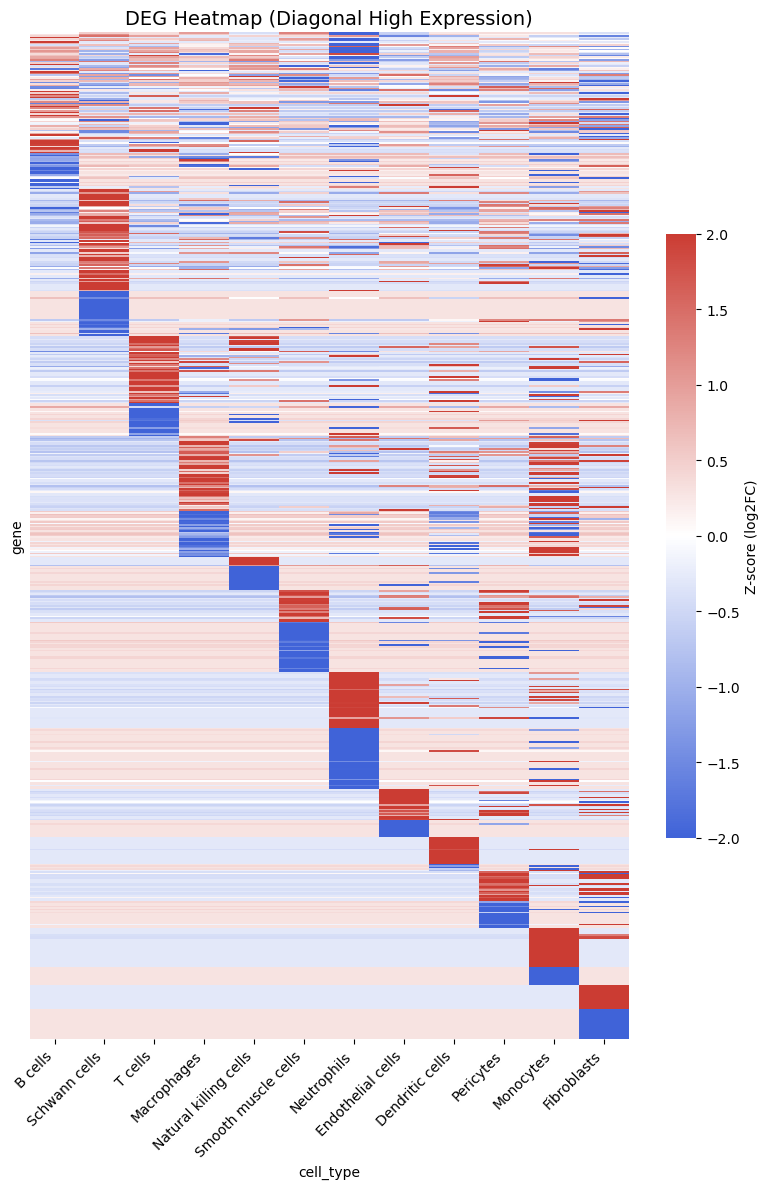

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. 构建 gene × cell_type 的 log2_fc 矩阵
heatmap_data = common_genes_df.pivot(index='gene', columns='cell_type', values='log2_fc')
heatmap_data = heatmap_data.fillna(0)

# 2. 设置固定列顺序
desired_order = [
    'B cells', 'Schwann cells', 'T cells', 'Macrophages', 'Natural killing cells',
    'Smooth muscle cells','Neutrophils', 'Endothelial cells', 'Dendritic cells','Pericytes',
     'Monocytes', 'Fibroblasts'
]
# 只保留存在的列
valid_order = [c for c in desired_order if c in heatmap_data.columns]
heatmap_data = heatmap_data[valid_order]

# 3. 为每个基因找到其所属细胞类型（来源）
gene_source = common_genes_df.drop_duplicates(subset=["gene"])[["gene", "cell_type"]].set_index("gene")

# 4. 给每个细胞类型分配排序位置
cell_order_dict = {cell: i for i, cell in enumerate(valid_order)}

# 5. 给每个基因打分：它的来源细胞类型在 valid_order 中的位置
gene_scores = gene_source["cell_type"].map(cell_order_dict)

# 6. 按 gene_scores 对行排序（模拟对角线效果）
# 最终按细胞类型组合后拼接
sorted_gene_list = []

for cell in valid_order:
    # 当前细胞类型下的 log2FC 表达
    fc_values = heatmap_data[cell]

    # 上调（红色）：从大到小排序
    up_genes = fc_values[fc_values > 0].sort_values(ascending=False).index.tolist()
    # 下调（蓝色）：从小到大排序
    down_genes = fc_values[fc_values < 0].sort_values().index.tolist()

    # 按顺序添加：红色在前，蓝色在后
    sorted_gene_list.extend(up_genes + down_genes)

# 去重，保持排序（因为有些基因可能在多个细胞类型中都调控）
from collections import OrderedDict
sorted_gene_list = list(OrderedDict.fromkeys(sorted_gene_list))

# 重新排序热图矩阵
heatmap_data_sorted = heatmap_data.loc[sorted_gene_list, valid_order]


#heatmap_data["__gene_order"] = gene_scores
#heatmap_data_sorted = heatmap_data.sort_values(by="__gene_order").drop(columns="__gene_order")
# 7. Z-score 标准化（按行，即每个基因）
heatmap_data_scaled = heatmap_data_sorted.sub(
    heatmap_data_sorted.mean(axis=1), axis=0
).div(
    heatmap_data_sorted.std(axis=1), axis=0
).fillna(0)
# 8. 自定义颜色映射（0=白色，负值=蓝，正值=红）
my_cmap = LinearSegmentedColormap.from_list(
    "refined",
    ["#4063D8", "white", "#CB3C33"]
)

# 9. 绘图
plt.figure(figsize=(8, 12))
sns.heatmap(
    heatmap_data_scaled,
    cmap=my_cmap,
    vmin=-2, vmax=2, center=0,
    xticklabels=True, yticklabels=False,
    cbar_kws={'label': 'Z-score (log2FC)', 'shrink': 0.6}
)

plt.title("DEG Heatmap (Diagonal High Expression)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("figures/DEG-r/heatmap_diag_logFC_scaled.pdf", dpi=300)
plt.show()


In [37]:
import os

# 创建一个文件夹存放结果
output_dir = "PPI_gene_lists"
os.makedirs(output_dir, exist_ok=True)

# 遍历每个细胞类型并保存文件
for cell_type, genes in filtered_genes_by_cell_type.items():
    file_path = os.path.join(output_dir, f"{cell_type}_PPI_genes.txt")
    with open(file_path, "w") as f:
        for gene in genes:
            f.write(gene + "\n")

print(f"所有细胞类型的基因列表已保存在 {output_dir} 文件夹中")


所有细胞类型的基因列表已保存在 PPI_gene_lists 文件夹中


In [38]:
import requests
import time

# STRING API 的基地址
STRING_API_URL = "https://string-db.org/api/json/network"


# 遍历每个细胞类型并提交基因列表
ppi_results = {}

for cell_type, genes in filtered_genes_by_cell_type.items():
    print(f"正在处理 {cell_type}...")

    # 组合基因为逗号分隔的字符串
    gene_list_str = "%0A".join(genes)

    # 构造 API 请求参数
    params = {
        "identifiers": gene_list_str,  # 基因列表
        "species": 10090,  # 物种 ID（10090 是小鼠，9606 是人）
        "required_score": 400,  # 设定交互分数阈值
        "add_nodes": 0,  # 不自动扩展邻居
    }

    # 发送 GET 请求
    response = requests.get(STRING_API_URL, params=params)

    if response.status_code == 200:
        ppi_results[cell_type] = response.json()
        print(f"{cell_type} PPI 结果获取成功")
    else:
        print(f"{cell_type} 失败, HTTP 状态码: {response.status_code}")

    # 避免 API 速率限制，暂停 1 秒
    time.sleep(1)

print("所有细胞类型的 PPI 结果已获取完毕！")

正在处理 gene...
gene 失败, HTTP 状态码: 400
正在处理 Smooth muscle cells...
Smooth muscle cells PPI 结果获取成功
正在处理 Endothelial cells...
Endothelial cells PPI 结果获取成功
正在处理 Macrophages...
Macrophages PPI 结果获取成功
正在处理 Fibroblasts...
Fibroblasts PPI 结果获取成功
正在处理 T cells...
T cells PPI 结果获取成功
正在处理 Neutrophils...
Neutrophils PPI 结果获取成功
正在处理 B cells...
B cells PPI 结果获取成功
正在处理 Dendritic cells...
Dendritic cells PPI 结果获取成功
正在处理 Pericytes...
Pericytes PPI 结果获取成功
正在处理 Natural killing cells...
Natural killing cells PPI 结果获取成功
正在处理 Schwann cells...
Schwann cells PPI 结果获取成功
正在处理 Monocytes...
Monocytes PPI 结果获取成功
所有细胞类型的 PPI 结果已获取完毕！


In [39]:
import os
import json

# 指定保存的文件夹名称
output_folder = "PPI_result"

# 在当前目录下创建文件夹（如果不存在）
os.makedirs(output_folder, exist_ok=True)

# 保存 JSON 文件到 PPI_results 文件夹
for cell_type, result in ppi_results.items():
    file_path = os.path.join(output_folder, f"{cell_type}_PPI.json")
    with open(file_path, "w") as f:
        json.dump(result, f, indent=4)

print(f"所有 PPI 结果已保存到 {output_folder} 文件夹！")

所有 PPI 结果已保存到 PPI_result 文件夹！


In [40]:
import pandas as pd
import os
import json

input_folder = "PPI_result"
output_folder = "PPI_edges_for_cytoscape"
os.makedirs(output_folder, exist_ok=True)

for filename in os.listdir(input_folder):
    if filename.endswith(".json"):
        cell_type = filename.replace("_PPI.json", "")
        with open(os.path.join(input_folder, filename), "r") as f:
            data = json.load(f)

        # 提取边信息
        edges = [
            {
                "Source": item["preferredName_A"],
                "Target": item["preferredName_B"],
                "Score": item["score"]
            }
            for item in data
        ]

        df_edges = pd.DataFrame(edges)
        df_edges.to_csv(os.path.join(output_folder, f"{cell_type}_edges.csv"), index=False)

print(f"所有细胞类型的边表已保存至 {output_folder}，可直接导入 Cytoscape。")


所有细胞类型的边表已保存至 PPI_edges_for_cytoscape，可直接导入 Cytoscape。


In [41]:
import os
import json
import networkx as nx
import pandas as pd

# 指定 PPI 结果文件夹
ppi_folder = "PPI_result"

# 初始化一个字典存储每个细胞类型的度中心度
degree_centrality_by_cell_type = {}

# 遍历 PPI_results 文件夹中的所有 JSON 文件
for file_name in os.listdir(ppi_folder):
    if file_name.endswith("_PPI.json"):  # 只处理 JSON 文件
        cell_type = file_name.replace("_PPI.json", "")  # 提取细胞类型
        file_path = os.path.join(ppi_folder, file_name)

        # 读取 JSON 数据
        with open(file_path, "r") as f:
            ppi_data = json.load(f)

        # 构建 PPI 网络
        G = nx.Graph()
        for interaction in ppi_data:
            protein1 = interaction["preferredName_A"]  # STRING 交互中的基因A
            protein2 = interaction["preferredName_B"]  # STRING 交互中的基因B
            G.add_edge(protein1, protein2)  # 添加边

        # 计算度中心度
        degree_centrality =  dict(G.degree())

        # 存储到字典
        degree_centrality_by_cell_type[cell_type] = degree_centrality

# 转换为 DataFrame，方便查看
df_list = []
for cell_type, centrality_dict in degree_centrality_by_cell_type.items():
    df = pd.DataFrame(centrality_dict.items(), columns=["Gene", "Degree Centrality"])
    df["Cell Type"] = cell_type  # 添加细胞类型列
    df_list.append(df)

# 合并所有细胞类型的数据
degree_centrality_df = pd.concat(df_list, ignore_index=True)

In [42]:
print(degree_centrality_df)

        Gene  Degree Centrality    Cell Type
0       Ccl2                 35    Pericytes
1      Tagln                 20    Pericytes
2        Dcn                 25    Pericytes
3      Pde4b                  2    Pericytes
4     Igfbp3                 12    Pericytes
...      ...                ...          ...
1164   Sept7                  1  Fibroblasts
1165  Cthrc1                  2  Fibroblasts
1166   Glis3                  1  Fibroblasts
1167   Myo10                  1  Fibroblasts
1168  Tm4sf1                  1  Fibroblasts

[1169 rows x 3 columns]


In [43]:
import numpy as np
import pandas as pd

# 假设 degree_centrality_df 已经加载，包含 'Gene' 和 'Cell Type' 列
# 假设 adata.obs['sample'] 包含 'ctrl', 'model', 'smi' 组的信息
# 假设 adata.var_names 是基因名，adata.X 是表达矩阵

# 创建存储 RL 结果的字典
rl_results = {}

# 遍历每个细胞类型
for cell_type in degree_centrality_df["Cell Type"].unique():
    # 获取该细胞类型的 PPI 基因
    ppi_genes = degree_centrality_df[degree_centrality_df["Cell Type"] == cell_type]["Gene"]
    
    # 确保这些基因在 adata.var_names 中
    valid_genes = [gene for gene in ppi_genes if gene in adata.var_names]
    
    # 获取对应基因在 ctrl, model, smi 组的表达值
    ctrl_expr = np.mean(adata[adata.obs["sample"] == "ctrl"][:, valid_genes].X, axis=0) + 1  # 避免 log(0)
    model_expr = np.mean(adata[adata.obs["sample"] == "model"][:, valid_genes].X, axis=0) + 1
    smi_expr = np.mean(adata[adata.obs["sample"] == "smi"][:, valid_genes].X, axis=0) + 1
    
    # 计算 log2 表达值
    log_ctrl = np.log2(ctrl_expr)
    log_model = np.log2(model_expr)
    log_smi = np.log2(smi_expr)
    
    # 计算 RL
    rl_values = (log_smi - log_model) / (log_ctrl - log_model)
    
    # 存储结果
    rl_results[cell_type] = pd.DataFrame({
        "Gene": valid_genes,
        "RL": rl_values
    })

# 合并所有细胞类型的 RL 结果
rl_df = pd.concat(rl_results, keys=rl_results.keys()).reset_index()
rl_df.rename(columns={"level_0": "Cell Type"}, inplace=True)  # 让细胞类型变成普通列

# 查看前几行
rl_df.head()

,Cell Type,level_1,Gene,RL
0,Pericytes,0,Ccl2,0.248916
1,Pericytes,1,Tagln,0.318782
2,Pericytes,2,Dcn,0.363198
3,Pericytes,3,Pde4b,0.087143
4,Pericytes,4,Igfbp3,5.830085


In [44]:
# 先创建一个空的 DataFrame 来存储最终的 EoR 结果
EoR_df = pd.DataFrame(columns=["Cell Type", "Gene", "RL", "EoR", "Change"])
#计算up和down的EoR
# 遍历每个细胞类型
for cell_type in log2_fc_change_df.columns[1:]:  # 跳过 'gene' 列
    # 获取该细胞类型在 log2_fc_change_df 中的 up/down 基因
    up_genes = log2_fc_change_df[log2_fc_change_df[cell_type] == "up"]["gene"]
    down_genes = log2_fc_change_df[log2_fc_change_df[cell_type] == "down"]["gene"]
    # 合并 up 和 down 基因
    selected_genes = pd.concat([up_genes, down_genes])
    
    # 在 rl_df 中筛选这些基因
    selected_rl = rl_df[(rl_df["Cell Type"] == cell_type) & (rl_df["Gene"].isin(selected_genes))].copy()
    
    # 确保 selected_rl 的基因都在 adata 中
    valid_genes = [gene for gene in selected_rl["Gene"] if gene in adata.var_names]
    if not valid_genes:
        continue  # 跳过没有有效基因的情况

    # 获取表达值
    ctrl_expr = np.mean(adata[adata.obs["sample"] == "ctrl"][:, valid_genes].X, axis=0) + 1
    model_expr = np.mean(adata[adata.obs["sample"] == "model"][:, valid_genes].X, axis=0) + 1
    
    # 计算 log2 表达值差异（方向性保留）
    log_ctrl = np.log2(ctrl_expr)
    log_model = np.log2(model_expr)
    # 计算 Eor
    EoR_1 = np.abs(log_model - log_ctrl)
    EoR= (EoR_1 > 0.5).astype(int)  # 逻辑判断，符合条件设为 1，否则设为 0
    # 添加 EoR 到表格中
    selected_rl = selected_rl[selected_rl["Gene"].isin(valid_genes)].copy()
    selected_rl["EoR"] = EoR

    # 过滤 EoR < -2 或 EoR > 0 的异常值（可选）
    selected_rl = selected_rl[(selected_rl["EoR"] >= 0) & (selected_rl["EoR"] <= 2)]

    # 添加 up/down 标注
    selected_rl["Change"] = selected_rl["Gene"].map(
        lambda g: "up" if g in up_genes.values else "down"
    )

    # 合并结果
    EoR_df = pd.concat([EoR_df, selected_rl])

# 重置索引
EoR_df.reset_index(drop=True, inplace=True)

# 查看前几行
print(EoR_df.head())


/tmp/ipykernel_97657/1618724152.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  EoR_df = pd.concat([EoR_df, selected_rl])


             Cell Type    Gene        RL EoR Change  level_1
0  Smooth muscle cells     Dcn  0.363198   1     up      2.0
1  Smooth muscle cells  Tyrobp -0.254019   1     up      3.0
2  Smooth muscle cells  S100a4  0.082369   1     up      5.0
3  Smooth muscle cells  Fcer1g -0.143088   1     up      8.0
4  Smooth muscle cells    C1qa  0.183851   1     up      9.0


In [45]:
unique_changes = EoR_df['Change'].value_counts()
print(unique_changes)


Change
up      365
down     43
Name: count, dtype: int64


In [46]:
import pandas as pd

# 合并两个 DataFrame，依据 Cell Type 和 Gene 两个键
RR_updown = EoR_df.merge(
    degree_centrality_df[["Gene", "Cell Type","Degree Centrality"]],
    on=["Gene", "Cell Type"],
    how="left"
)

print(RR_updown.columns.tolist())


['Cell Type', 'Gene', 'RL', 'EoR', 'Change', 'level_1', 'Degree Centrality']


In [47]:
# Step 3: 计算 RR = EoR × Degree Centrality
RR_updown["RR_updown"] = RR_updown["EoR"] * RR_updown["Degree Centrality"]

# Step 4: 查看结果
print(RR_updown.head())

             Cell Type    Gene        RL EoR Change  level_1  \
0  Smooth muscle cells     Dcn  0.363198   1     up      2.0   
1  Smooth muscle cells  Tyrobp -0.254019   1     up      3.0   
2  Smooth muscle cells  S100a4  0.082369   1     up      5.0   
3  Smooth muscle cells  Fcer1g -0.143088   1     up      8.0   
4  Smooth muscle cells    C1qa  0.183851   1     up      9.0   

   Degree Centrality RR_updown  
0                 17        17  
1                  8         8  
2                  7         7  
3                  5         5  
4                  6         6  


In [48]:
EoR_all_list = []

for cell_type in rl_df["Cell Type"].unique():
    # 筛选出该细胞类型的数据
    sub_df = rl_df[rl_df["Cell Type"] == cell_type].copy()
    
    # 计算 EoR_all
    sub_df["EoR_all"] = 1 - abs(1 - sub_df["RL"])
    
    # 过滤 EoR_all > 0 且 < 2
    sub_df = sub_df[(sub_df["EoR_all"] > 0) & (sub_df["EoR_all"] < 2)]
    # 添加细胞类型列
    sub_df["Cell Type"] = cell_type
    # 将结果添加到列表中
    EoR_all_list.append(sub_df[["Cell Type", "Gene", "RL", "EoR_all"]])

# 将列表中的数据合并为一个 DataFrame
EoR_all_df = pd.concat(EoR_all_list, ignore_index=True)

EoR_all_df

,Cell Type,Gene,RL,EoR_all
0,Pericytes,Ccl2,0.248916,0.248916
1,Pericytes,Tagln,0.318782,0.318782
2,Pericytes,Dcn,0.363198,0.363198
3,Pericytes,Pde4b,0.087143,0.087143
4,Pericytes,Hspa1b,0.515683,0.515683
...,...,...,...,...
551,Fibroblasts,Cacna2d1,0.484458,0.484458
552,Fibroblasts,Marcksl1,1.042386,0.957614
553,Fibroblasts,Sept7,1.000000,1.000000
554,Fibroblasts,Cthrc1,0.167544,0.167544


In [49]:
# **合并 EoR_all_df.df 和 degree_centrality_df**
RR_all = EoR_all_df.merge(
    degree_centrality_df[["Gene", "Cell Type", "Degree Centrality"]],
    on=["Gene", "Cell Type"],
    how="left"
)
# Step 3: 计算 RR = EoR × Degree Centrality
RR_all["RR_all"] = RR_all["EoR_all"] * RR_all["Degree Centrality"]
# Step 4: 查看结果
print(RR_all.head())

   Cell Type    Gene        RL   EoR_all  Degree Centrality    RR_all
0  Pericytes    Ccl2  0.248916  0.248916                 35  8.712069
1  Pericytes   Tagln  0.318782  0.318782                 20  6.375641
2  Pericytes     Dcn  0.363198  0.363198                 25  9.079945
3  Pericytes   Pde4b  0.087143  0.087143                  2  0.174286
4  Pericytes  Hspa1b  0.515683  0.515683                 16  8.250923


In [50]:
# 1. 准备两个 DataFrame，只保留必要列
df_updown = RR_updown[["Cell Type", "Gene", "RR_updown"]].copy()
df_all = RR_all[["Cell Type", "Gene", "RR_all", "Degree Centrality"]].copy()

# 2. 合并两个表格，按 Cell Type 和 Gene 对齐
RR_df = pd.merge(df_all, df_updown, on=["Cell Type", "Gene"], how="left")

# 3. 把缺失的 RR_updown 值填为 0
RR_df["RR_updown"] = RR_df["RR_updown"].fillna(0)

# 4. 可选：调整列顺序
RR_df = RR_df[["Cell Type", "Gene", "RR_updown", "RR_all", "Degree Centrality"]]

# 5. 查看结果
print(RR_df.head())


   Cell Type    Gene  RR_updown    RR_all  Degree Centrality
0  Pericytes    Ccl2         35  8.712069                 35
1  Pericytes   Tagln         20  6.375641                 20
2  Pericytes     Dcn          0  9.079945                 25
3  Pericytes   Pde4b          0  0.174286                  2
4  Pericytes  Hspa1b          0  8.250923                 16


/tmp/ipykernel_97657/3236497438.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  RR_df["RR_updown"] = RR_df["RR_updown"].fillna(0)


In [51]:
# 增加NRI列：RR_updown + RR_all
RR_df['NRI'] = RR_df['RR_updown'] + RR_df['RR_all']

# 查看结果
print(RR_df)

       Cell Type      Gene  RR_updown    RR_all  Degree Centrality        NRI
0      Pericytes      Ccl2         35  8.712069                 35  43.712069
1      Pericytes     Tagln         20  6.375641                 20  26.375641
2      Pericytes       Dcn          0  9.079945                 25   9.079945
3      Pericytes     Pde4b          0  0.174286                  2   0.174286
4      Pericytes    Hspa1b          0  8.250923                 16   8.250923
..           ...       ...        ...       ...                ...        ...
551  Fibroblasts  Cacna2d1          0  0.484458                  1   0.484458
552  Fibroblasts  Marcksl1          1  0.957614                  1   1.957614
553  Fibroblasts     Sept7          1  1.000000                  1   2.000000
554  Fibroblasts    Cthrc1          2  0.335088                  2   2.335088
555  Fibroblasts     Glis3          0  0.196015                  1   0.196015

[556 rows x 6 columns]


In [52]:
#整合大的PPI

In [53]:
import pandas as pd

# Step 1: 合并所有 PPI 边 + 记录节点属性
edges_list = []
node_annotations = {}

for cell_type, interactions in ppi_results.items():
    for interaction in interactions:
        protein1 = interaction["preferredName_A"]
        protein2 = interaction["preferredName_B"]
        score = interaction["score"]

        # 添加一条边
        edges_list.append((protein1, protein2, score))

        # 记录 protein1 属于哪个细胞类型
        if protein1 not in node_annotations:
            node_annotations[protein1] = set()
        node_annotations[protein1].add(cell_type)

        # 同理记录 protein2
        if protein2 not in node_annotations:
            node_annotations[protein2] = set()
        node_annotations[protein2].add(cell_type)

# Step 2: 构造边表 DataFrame
edges_df = pd.DataFrame(edges_list, columns=["source", "target", "score"])
edges_df.drop_duplicates(inplace=True)

# Step 3: 构造节点表（一个基因一个节点，多细胞类型用 ; 连接）
nodes_df = pd.DataFrame([
    {"gene": gene, "cell_types": ";".join(sorted(types))}
    for gene, types in node_annotations.items()
])

# Step 4: 保存为 Cytoscape 兼容格式（TSV）
output_dir = "PPI_merged_for_Cytoscape"
os.makedirs(output_dir, exist_ok=True)

edges_df.to_csv(os.path.join(output_dir, "edges.tsv"), sep="\t", index=False)
nodes_df.to_csv(os.path.join(output_dir, "nodes.tsv"), sep="\t", index=False)

print(f"已保存 Cytoscape 所需的 edges 和 nodes 文件到 {output_dir}/")


已保存 Cytoscape 所需的 edges 和 nodes 文件到 PPI_merged_for_Cytoscape/


In [54]:
#加上log2_fc，NRI 做节点属性
import pandas as pd
import os

# Step 1: 计算 log2_fc 的绝对值平均
gene_fc_summary = (
    filtered_genes_df
    .assign(abs_log2_fc = filtered_genes_df["log2_fc"].abs())
    .groupby("gene")["abs_log2_fc"]
    .mean()
    .reset_index()
    .rename(columns={"abs_log2_fc": "mean_abs_log2_fc"})
)

# Step 2: 聚合 NRI 信息（按 gene 取平均）
#nri_summary = (
#    RR_df
#    .groupby("Gene")["NRI"]
#    .mean()
#    .reset_index()
#    .rename(columns={"Gene": "gene", "NRI": "mean_NRI"})
#)

# 如需保留 RR_updown 和 RR_all 也可以加上
# 可选扩展：聚合多个指标
rr_multi = (
    RR_df
    .groupby("Gene")[["RR_updown", "RR_all", "NRI"]]
    .mean()
    .reset_index()
    .rename(columns={"Gene": "gene"})
)

# Step 3: 将这些信息合并进 nodes_df
nodes_df = nodes_df.merge(gene_fc_summary, how="left", on="gene")
nodes_df = nodes_df.merge(rr_multi, how="left", on="gene")

# Step 4: 保存为 Cytoscape 节点表
output_dir = "PPI_merged_for_Cytoscape"
os.makedirs(output_dir, exist_ok=True)

nodes_df.to_csv(os.path.join(output_dir, "nodes.tsv"), sep="\t", index=False)
edges_df.to_csv(os.path.join(output_dir, "edges.tsv"), sep="\t", index=False)

print("✅ 已将 log2_fc、NRI、RR 等节点属性合并并保存到 Cytoscape 的 nodes.tsv 文件中")


✅ 已将 log2_fc、NRI、RR 等节点属性合并并保存到 Cytoscape 的 nodes.tsv 文件中


In [55]:
# 按 Cell Type 分组并求 NRI 总和
NRI_df = RR_df.groupby('Cell Type', as_index=False)['NRI'].sum()

# 查看结果
print(NRI_df)

                Cell Type         NRI
0                 B cells  184.012558
1         Dendritic cells  240.122600
2       Endothelial cells  323.932985
3             Fibroblasts  544.643137
4             Macrophages  342.511702
5               Monocytes  676.426681
6   Natural killing cells  271.731813
7             Neutrophils  350.904680
8               Pericytes  463.487794
9           Schwann cells  283.164696
10    Smooth muscle cells  258.120729
11                T cells  266.249453


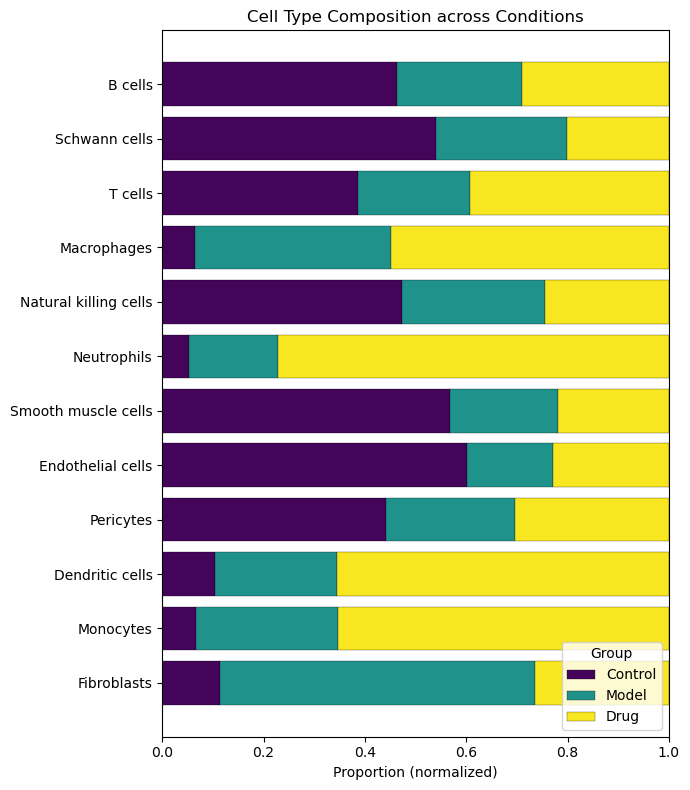

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: 统计样本中每个细胞类型的比例
ct_counts = pd.crosstab(adata.obs['sample'], adata.obs['cell_type'])
ct_props = ct_counts.div(ct_counts.sum(axis=1), axis=0)
# Step 2: 分组均值（需要确保 sample 名称中有 control/model/drug 的关键词）
grouped = {
    'control': ct_props.loc[ct_props.index.str.contains("ctrl")].mean(),
    'model': ct_props.loc[ct_props.index.str.contains("model")].mean(),
    'drug': ct_props.loc[ct_props.index.str.contains("smi")].mean(),
}
# 你已有的：每组对应 Series，索引是细胞类型
df = pd.DataFrame(grouped)  # index: cell_type, columns: group

# 设置细胞类型显示顺序
cell_order = [
    'Fibroblasts','Monocytes','Dendritic cells', 'Pericytes', 'Endothelial cells', 
    'Smooth muscle cells', 'Neutrophils', 'Natural killing cells', 'Macrophages', 
    'T cells', 'Schwann cells', 'B cells'
]
cell_order_valid = [ct for ct in cell_order if ct in df.index]

# 重新排序并归一化（行和为1）
df = df.loc[cell_order_valid]
df_norm = df.div(df.sum(axis=1), axis=0)  # 每行归一化

# 设置颜色
colors = {
    'control': '#44045A',   
    'model': '#1F928B',    
    'drug': '#F8E620'      
}

# 绘图：横向堆叠条形图
fig, ax = plt.subplots(figsize=(7, 8))

left = [0] * len(df_norm)  # 起始位置
for group in ['control', 'model', 'drug']:
    ax.barh(df_norm.index, df_norm[group], left=left,
            label=group.capitalize(), color=colors[group],
            edgecolor='black',linewidth=0.2)
    # 更新 left 为下次绘图起点
    left = [i + j for i, j in zip(left, df_norm[group])]

# 美化
ax.set_xlim(0, 1)
ax.set_xlabel("Proportion (normalized)")
ax.set_title("Cell Type Composition across Conditions")
ax.legend(title="Group", loc='lower right')
plt.tight_layout()
plt.savefig("figures/cell_type_proportions.pdf", format='pdf')
plt.show()

In [57]:
import liana
import pandas as pd

# 假设你已经有adata对象
# 细胞表达数据
expression_matrix = adata.raw.X  # 或者使用 adata.X，根据需要选择

# 细胞类型信息
cell_types = adata.obs['cell_type']  # 这列是细胞的类型信息

# 其他的元数据（例如样本信息）
metadata = adata.obs[['sample', 'cell_type']]

# 配体-受体数据库：你可以选择liana的默认数据库，或者使用你自己的数据库
receptor_ligand_database = "interaction_table.csv"  # 可以是数据库的路径或者数据库的名称




In [58]:
from liana.method import cellphonedb  # 直接调用 cellphonedb
adata.raw = adata
  # 禁用 .raw，使用 adata.X 中的数据
# 运行细胞通讯分析
cellphonedb(
    adata=adata,
    groupby='cell_type',# 表示细胞类型的列名
    resource_name='mouseconsensus',  
    expr_prop=0.01,
    min_cells=2,
    de_method='t-test',
    n_perms=1000,
    seed=1337,
    n_jobs=1,
    verbose=True
)

adata.uns['liana_res'].head()

Using resource `mouseconsensus`.
Using `.raw`!
Converting to sparse csr matrix!
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['NEWGENE_1308171', 'NEWGENE_1310139', 'NEWGENE_619861', 'Trnas-cga_2'] contain `_`. Consider replacing those!
0.69 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 34465 samples and 326 features


100%|██████████| 1000/1000 [00:14<00:00, 67.50it/s]


,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
2008,S100a8,S100a8,3.826144,0.875193,Cd69,Cd69,1.970848,0.853741,Neutrophils,B cells,2.898496,0.0
18879,S100a8,S100a8,3.826144,0.875193,Cd68,Cd68,1.955777,0.925452,Neutrophils,Monocytes,2.890961,0.0
22391,S100a8,S100a8,3.826144,0.875193,Cd69,Cd69,1.856921,0.858427,Neutrophils,Natural killing cells,2.841533,0.0
37978,S100a8,S100a8,3.826144,0.875193,Cd69,Cd69,1.829955,0.814332,Neutrophils,T cells,2.828050,0.0
15551,S100a8,S100a8,3.826144,0.875193,Cd68,Cd68,1.743106,0.923364,Neutrophils,Macrophages,2.784625,0.0


In [59]:
# 分别提取不同的组
smi_adata = adata[adata.obs['sample'] == 'smi'].copy()
model_adata = adata[adata.obs['sample'] == 'model'].copy()
ctrl_adata = adata[adata.obs['sample'] == 'ctrl'].copy()

# 检查每个子集的数据是否正确
print(smi_adata.shape)
print(model_adata.shape)
print(ctrl_adata.shape)

from liana.method import cellphonedb

# 为 smi 组创建细胞通讯分析
smi_results = cellphonedb(
    adata=smi_adata,
    groupby='cell_type',  # 表示细胞类型的列名
    resource_name='mouseconsensus',  
    expr_prop=0.01,
    min_cells=2,
    de_method='t-test',
    n_perms=1000,
    seed=1337,
    n_jobs=1,
    verbose=True
)
# 为 model 组创建细胞通讯分析
model_results = cellphonedb(
    adata=model_adata,
    groupby='cell_type',
    resource_name='mouseconsensus',  
    expr_prop=0.01,
    min_cells=2,
    de_method='t-test',
    n_perms=1000,
    seed=1337,
    n_jobs=1,
    verbose=True
)
# 为 ctrl 组创建细胞通讯分析
ctrl_results = cellphonedb(
    adata=ctrl_adata,
    groupby='cell_type',
    resource_name='mouseconsensus',  
    expr_prop=0.01,
    min_cells=2,
    de_method='t-test',
    n_perms=1000,
    seed=1337,
    n_jobs=1,
    verbose=True
)

Using resource `mouseconsensus`.
Using `.raw`!
Converting to sparse csr matrix!


(11952, 3607)
(11951, 3607)
(10562, 3607)


/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
152 features of mat are empty, they will be removed.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['Trnas-cga_2'] contain `_`. Consider replacing those!
0.69 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 11952 samples and 326 features


100%|██████████| 1000/1000 [00:06<00:00, 151.03it/s]
Using resource `mouseconsensus`.
Using `.raw`!
Converting to sparse csr matrix!
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
931 features of mat are empty, they will be removed.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['NEWGENE_1308171', 'NEWGENE_1310139', 'NEWGENE_6198

Generating ligand-receptor stats for 11951 samples and 298 features


100%|██████████| 1000/1000 [00:06<00:00, 153.83it/s]
Using resource `mouseconsensus`.
Using `.raw`!
Converting to sparse csr matrix!
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
156 features of mat are empty, they will be removed.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:150: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/liana/method/_pipe_utils/_pre.py:153: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
['Trnas-cga_2'] contain `_`. Consider replacing thos

Generating ligand-receptor stats for 10562 samples and 325 features


100%|██████████| 1000/1000 [00:05<00:00, 189.62it/s]


In [60]:
ctrl_adata.uns['liana_res'].head()

,ligand,ligand_complex,ligand_means,ligand_props,receptor,receptor_complex,receptor_means,receptor_props,source,target,lr_means,cellphone_pvals
18572,Ccl5,Ccl5,4.331737,0.979695,Ccr1,Ccr1,1.467515,0.655556,Natural killing cells,Neutrophils,2.899626,0.0
1087,S100a8,S100a8,3.631266,0.900000,Cd69,Cd69,2.057537,0.881890,Neutrophils,B cells,2.844402,0.0
16202,S100a8,S100a8,3.631266,0.900000,Cd69,Cd69,1.994473,0.903553,Neutrophils,Natural killing cells,2.812870,0.0
13428,S100a8,S100a8,3.631266,0.900000,Itgb2,Itgb2,1.916859,0.911392,Neutrophils,Monocytes,2.774063,0.0
7214,Dcn,Dcn,4.257135,1.000000,Egfr,Egfr,1.253195,0.842304,Fibroblasts,Fibroblasts,2.755165,0.0


In [61]:
import pandas as pd

# 从 _adata 中提取 liana 结果
drug_df = smi_adata.uns['liana_res'].groupby(['source', 'target'])['lr_means'].mean().reset_index()
drug_df.rename(columns={'lr_means': 'value'}, inplace=True)

# 只保留必要的列
drug_df = drug_df[['source', 'target', 'value']]

# 保存为 CSV
drug_df.to_csv('figures/drug_chord.csv', index=False)


In [62]:
import pandas as pd

# 取出 liana 结果
# 先聚合：每个 source-target 对只保留一个 lr_means（比如取平均值）
ctrl_df = ctrl_adata.uns['liana_res'].groupby(['source', 'target'])['lr_means'].mean().reset_index()
ctrl_df.rename(columns={'lr_means': 'ctrl'}, inplace=True)

model_df = model_adata.uns['liana_res'].groupby(['source', 'target'])['lr_means'].mean().reset_index()
model_df.rename(columns={'lr_means': 'model'}, inplace=True)

smi_df = smi_adata.uns['liana_res'].groupby(['source', 'target'])['lr_means'].mean().reset_index()
smi_df.rename(columns={'lr_means': 'smi'}, inplace=True)
smi_df.to_csv("figures/smi_chord_data.csv", index=False)
# 合并
merged_df = ctrl_df.merge(model_df, on=['source', 'target'], how='outer')
merged_df = merged_df.merge(smi_df, on=['source', 'target'], how='outer')
merged_df = merged_df.fillna(0)

# 差异列
merged_df['model_vs_ctrl'] = merged_df['model'] - merged_df['ctrl']
merged_df['smi_vs_ctrl'] = merged_df['smi'] - merged_df['ctrl']

# 选择差异显著的通信对
model_diff_df = merged_df[merged_df['model_vs_ctrl'].abs() > 0.01][['source', 'target', 'model_vs_ctrl']]
smi_diff_df = merged_df[merged_df['smi_vs_ctrl'].abs() > 0.01][['source', 'target', 'smi_vs_ctrl']]

# 重命名统一列名
model_diff_df.columns = ['source', 'target', 'value']
smi_diff_df.columns = ['source', 'target', 'value']

# 保存为 CSV 文件供 R 使用
model_diff_df.to_csv('figures/model_vs_ctrl_chord.csv', index=False)
smi_diff_df.to_csv('figures/smi_vs_ctrl_chord.csv', index=False)


In [63]:
print(smi_diff_df)

      source                 target     value
0    B cells                B cells -0.015879
1    B cells        Dendritic cells  0.046733
2    B cells      Endothelial cells  0.016570
3    B cells            Fibroblasts  0.043447
4    B cells            Macrophages  0.021309
..       ...                    ...       ...
138  T cells  Natural killing cells  0.051193
139  T cells            Neutrophils  0.041748
140  T cells              Pericytes  0.042306
142  T cells    Smooth muscle cells  0.052116
143  T cells                T cells  0.025266

[125 rows x 3 columns]


In [64]:
import pandas as pd
import holoviews as hv
from bokeh.io.export import export_svgs
from bokeh.io import output_file
import os
from bokeh.io import export_svgs
from bokeh.plotting import output_notebook
import panel as pn
pn.extension()
output_notebook()
# 用 model_diff_df 作为例子（包含 source, target, value）
df = model_diff_df.copy()

# value 不能为负，为可视化建议取绝对值或正负分开画两张图
df['abs_value'] = df['value'].abs()

# 节点列表（可附加颜色/大小等属性）
nodes = list(set(df['source']) | set(df['target']))

import holoviews as hv
hv.extension('bokeh')

# 构建 chords 数据
chords_data = df[['source', 'target', 'abs_value']].copy()
chords_data.columns = ['Source', 'Target', 'Value']

# 构建节点属性表
nodes_df = pd.DataFrame({'name': nodes})

# 创建 chord 图
chord = hv.Chord((chords_data, hv.Dataset(nodes_df, 'name')))
chord.opts(
    width=600, height=600, 
    labels='name',
    cmap='Category20', 
    edge_color=hv.dim('Source'),
    node_color=hv.dim('name'),
    edge_line_width=hv.dim('Value') * 10,  # 控制宽度
    title="Model vs Ctrl Communication"
)



Loading BokehJS ...

:Chord   [Source,Target]   (Value)

In [65]:
import pandas as pd

# 提取每个对象的 liana_res
smi_results = smi_adata.uns['liana_res']
model_results = model_adata.uns['liana_res']
ctrl_results = ctrl_adata.uns['liana_res']

# 保留 p-value < 0.05 的配受体对
smi_results_filtered = smi_results[smi_results['cellphone_pvals'] < 0.05]
model_results_filtered = model_results[model_results['cellphone_pvals'] < 0.05]
ctrl_results_filtered = ctrl_results[ctrl_results['cellphone_pvals'] < 0.05]

# 提取我们需要的列： ligand, receptor, lr_means
smi_results_filtered = smi_results_filtered[['ligand', 'receptor', 'lr_means', 'source', 'target']]
model_results_filtered = model_results_filtered[['ligand', 'receptor', 'lr_means', 'source', 'target']]
ctrl_results_filtered = ctrl_results_filtered[['ligand', 'receptor', 'lr_means', 'source', 'target']]

# 合并这三个结果，按 ligand 和 receptor 配对
merged_results = pd.merge(smi_results_filtered, model_results_filtered, on=['ligand', 'receptor', 'source', 'target'], suffixes=('_smi', '_model'))
merged_results = pd.merge(merged_results, ctrl_results_filtered, on=['ligand', 'receptor', 'source', 'target'])

# 计算 IAB,g1g2 和 RLAB,g1g2
# IAB,g1g2 = lr_means 对应的 smi, model, ctrl 值
merged_results['IAB_g1g2_smi'] = merged_results['lr_means_smi']
merged_results['IAB_g1g2_model'] = merged_results['lr_means_model']
merged_results['IAB_g1g2_ctrl'] = merged_results['lr_means']

# 计算 RLAB,g1g2
merged_results['RLAB_g1g2'] = (merged_results['IAB_g1g2_smi'] - merged_results['IAB_g1g2_model']) / (merged_results['IAB_g1g2_ctrl'] - merged_results['IAB_g1g2_model'])

# 输出筛选后的结果
print(merged_results[['ligand', 'receptor', 'source', 'target', 'RLAB_g1g2']].head())


   ligand receptor       source                 target  RLAB_g1g2
0  S100a8     Cd69  Neutrophils                T cells  -1.877422
1  S100a8     Cd68  Neutrophils              Monocytes  -0.682030
2  S100a8     Cd69  Neutrophils                B cells   2.032673
3  S100a8     Cd68  Neutrophils            Macrophages  -1.713518
4  S100a8     Cd69  Neutrophils  Natural killing cells   1.355449


In [66]:
import numpy as np

# 定义一个新的列 EoRCAB_g1g2，基于 RLAB_g1g2 计算
merged_results['EoRCAB_g1g2'] = np.where(
    (1 - np.abs(1 - merged_results['RLAB_g1g2'])) <= 0, 
    0, 
    1
)

# 查看结果
print(merged_results[['ligand', 'receptor', 'source', 'target', 'RLAB_g1g2', 'EoRCAB_g1g2']].head())


   ligand receptor       source                 target  RLAB_g1g2  EoRCAB_g1g2
0  S100a8     Cd69  Neutrophils                T cells  -1.877422            0
1  S100a8     Cd68  Neutrophils              Monocytes  -0.682030            0
2  S100a8     Cd69  Neutrophils                B cells   2.032673            0
3  S100a8     Cd68  Neutrophils            Macrophages  -1.713518            0
4  S100a8     Cd69  Neutrophils  Natural killing cells   1.355449            1


In [67]:
import os
import json
import networkx as nx
from itertools import combinations
from collections import defaultdict


In [68]:
#读取所有 PPI 图
ppi_dir = "PPI_result"
ppi_graphs = {}

for file in os.listdir(ppi_dir):
    if file.endswith("_PPI.json"):
        cell_type = file.replace("_PPI.json", "")
        with open(os.path.join(ppi_dir, file)) as f:
            interactions = json.load(f)

        # 初始化图
        G = nx.Graph()
        for entry in interactions:
            g1 = entry['preferredName_A']
            g2 = entry['preferredName_B']
            score = entry.get('score', 0.0)
            G.add_edge(g1, g2, weight=score)
        
        ppi_graphs[cell_type] = G


In [69]:
#构建细胞类型对的并集图
# 所有细胞类型两两组合（不重复）
cell_type_pairs = list(combinations(ppi_graphs.keys(), 2))

# 用于保存每个细胞类型对的中心性
bc_results = defaultdict(dict)


In [70]:
#为每一细胞类型对计算节点中心性
for ct1, ct2 in cell_type_pairs:
    print(f"计算 {ct1} 与 {ct2} 的并集图...")

    # 获取各自图
    G1 = ppi_graphs[ct1]
    G2 = ppi_graphs[ct2]

    # 合并图
    G_union = nx.compose(G1, G2)  # networkx 提供的图并集函数

    # 计算介数中心性（节点级）
    bc = nx.betweenness_centrality(G_union, normalized=True)

    # 保存
    bc_results[(ct1, ct2)] = bc


计算 Pericytes 与 Schwann cells 的并集图...
计算 Pericytes 与 Natural killing cells 的并集图...
计算 Pericytes 与 T cells 的并集图...
计算 Pericytes 与 Neutrophils 的并集图...
计算 Pericytes 与 Endothelial cells 的并集图...
计算 Pericytes 与 Monocytes 的并集图...
计算 Pericytes 与 Smooth muscle cells 的并集图...
计算 Pericytes 与 Dendritic cells 的并集图...
计算 Pericytes 与 Macrophages 的并集图...
计算 Pericytes 与 B cells 的并集图...
计算 Pericytes 与 Fibroblasts 的并集图...
计算 Schwann cells 与 Natural killing cells 的并集图...
计算 Schwann cells 与 T cells 的并集图...
计算 Schwann cells 与 Neutrophils 的并集图...
计算 Schwann cells 与 Endothelial cells 的并集图...
计算 Schwann cells 与 Monocytes 的并集图...
计算 Schwann cells 与 Smooth muscle cells 的并集图...
计算 Schwann cells 与 Dendritic cells 的并集图...
计算 Schwann cells 与 Macrophages 的并集图...
计算 Schwann cells 与 B cells 的并集图...
计算 Schwann cells 与 Fibroblasts 的并集图...
计算 Natural killing cells 与 T cells 的并集图...
计算 Natural killing cells 与 Neutrophils 的并集图...
计算 Natural killing cells 与 Endothelial cells 的并集图...
计算 Natural killing cells 与 Monocytes 的并集图...

In [71]:
print(merged_results.head())


   ligand receptor  lr_means_smi       source                 target  \
0  S100a8     Cd69      2.991401  Neutrophils                T cells   
1  S100a8     Cd68      2.970644  Neutrophils              Monocytes   
2  S100a8     Cd69      2.952621  Neutrophils                B cells   
3  S100a8     Cd68      2.892350  Neutrophils            Macrophages   
4  S100a8     Cd69      2.852504  Neutrophils  Natural killing cells   

   lr_means_model  lr_means  IAB_g1g2_smi  IAB_g1g2_model  IAB_g1g2_ctrl  \
0        2.732963  2.595307      2.991401        2.732963       2.595307   
1        2.766920  2.468216      2.970644        2.766920       2.468216   
2        2.739607  2.844402      2.952621        2.739607       2.844402   
3        2.640632  2.493730      2.892350        2.640632       2.493730   
4        2.701364  2.812870      2.852504        2.701364       2.812870   

   RLAB_g1g2  EoRCAB_g1g2  
0  -1.877422            0  
1  -0.682030            0  
2   2.032673            0 

In [72]:
# 新建一个列表保存计算结果
bc_ab_values = []

# 遍历 merged_results 的每一行
for _, row in merged_results.iterrows():
    # 获取细胞对
    ct_pair = tuple(sorted([row['source'], row['target']]))  # 注意一定要sorted，与你构建 bc_results 的方式一致

    # 获取基因
    g1 = row['ligand']
    g2 = row['receptor']

    # 获取该细胞类型对的介数中心性字典
    bc_dict = bc_results.get(ct_pair, {})

    # 取出对应基因的介数中心性值，若没有就设为0
    bc_g1 = bc_dict.get(g1, 0.0)
    bc_g2 = bc_dict.get(g2, 0.0)

    # 计算平均值
    bc_mean = (bc_g1 + bc_g2) / 2

    # 保存
    bc_ab_values.append(bc_mean)

# 添加为新列
merged_results['BC_AB_g1g2'] = bc_ab_values


In [73]:
print(merged_results.head())

   ligand receptor  lr_means_smi       source                 target  \
0  S100a8     Cd69      2.991401  Neutrophils                T cells   
1  S100a8     Cd68      2.970644  Neutrophils              Monocytes   
2  S100a8     Cd69      2.952621  Neutrophils                B cells   
3  S100a8     Cd68      2.892350  Neutrophils            Macrophages   
4  S100a8     Cd69      2.852504  Neutrophils  Natural killing cells   

   lr_means_model  lr_means  IAB_g1g2_smi  IAB_g1g2_model  IAB_g1g2_ctrl  \
0        2.732963  2.595307      2.991401        2.732963       2.595307   
1        2.766920  2.468216      2.970644        2.766920       2.468216   
2        2.739607  2.844402      2.952621        2.739607       2.844402   
3        2.640632  2.493730      2.892350        2.640632       2.493730   
4        2.701364  2.812870      2.852504        2.701364       2.812870   

   RLAB_g1g2  EoRCAB_g1g2  BC_AB_g1g2  
0  -1.877422            0    0.000000  
1  -0.682030            0    0

In [74]:
merged_results["CCRS_ABg1g2"] = merged_results["EoRCAB_g1g2"] * merged_results["BC_AB_g1g2"]
print(merged_results[["source","target","ligand", "receptor", "EoRCAB_g1g2", "BC_AB_g1g2", "CCRS_ABg1g2"]].head())


        source                 target  ligand receptor  EoRCAB_g1g2  \
0  Neutrophils                T cells  S100a8     Cd69            0   
1  Neutrophils              Monocytes  S100a8     Cd68            0   
2  Neutrophils                B cells  S100a8     Cd69            0   
3  Neutrophils            Macrophages  S100a8     Cd68            0   
4  Neutrophils  Natural killing cells  S100a8     Cd69            1   

   BC_AB_g1g2  CCRS_ABg1g2  
0    0.000000     0.000000  
1    0.000000     0.000000  
2    0.000000     0.000000  
3    0.000000     0.000000  
4    0.005538     0.005538  


In [75]:
# 按 source-target 分组，计算 CCRS_AB = sum(BC_AB_g1g2 × RLAB_g1g2)
ccrs_df = (
    merged_results
    .groupby(['source', 'target'])
    .apply(lambda df: (df['BC_AB_g1g2'] * df['EoRCAB_g1g2']).sum())
    .reset_index(name='CCRS_AB')
)
print(ccrs_df)


      source               target   CCRS_AB
0    B cells              B cells  0.000000
1    B cells      Dendritic cells  0.000000
2    B cells    Endothelial cells  0.000000
3    B cells          Fibroblasts  0.139753
4    B cells          Macrophages  0.000000
..       ...                  ...       ...
139  T cells          Neutrophils  0.000000
140  T cells            Pericytes  0.057065
141  T cells        Schwann cells  0.033327
142  T cells  Smooth muscle cells  0.000000
143  T cells              T cells  0.000000

[144 rows x 3 columns]


/tmp/ipykernel_97657/4187806831.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


In [76]:
#排序输出前几位的关键细胞对：
ccrs_df_sorted = ccrs_df.sort_values(by='CCRS_AB', ascending=False)
print(ccrs_df_sorted.head(5))



                source           target   CCRS_AB
16     Dendritic cells      Macrophages  0.320152
15     Dendritic cells      Fibroblasts  0.308074
37         Fibroblasts  Dendritic cells  0.235034
27   Endothelial cells      Fibroblasts  0.198182
107          Pericytes          T cells  0.160866


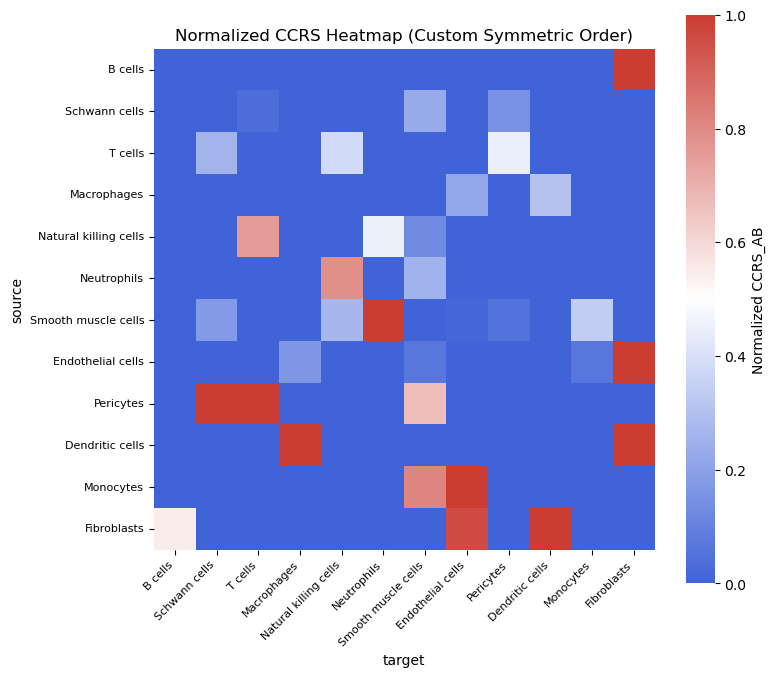

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# 1. 构建对称矩阵
ccrs_matrix = ccrs_df.pivot(index='source', columns='target', values='CCRS_AB')

# 2. 自定义行和列的顺序
custom_order = [
    'B cells', 'Schwann cells', 'T cells', 'Macrophages', 'Natural killing cells',
    'Neutrophils', 'Smooth muscle cells', 'Endothelial cells', 'Pericytes',
    'Dendritic cells', 'Monocytes', 'Fibroblasts'
]
reversed_order = custom_order[::-1]

# 3. 按指定顺序重新索引
ccrs_matrix = ccrs_matrix.reindex(index=custom_order, columns=custom_order)

# 4. 归一化 CCRS_AB 到 [0, 1]
# 对数变换（log1p），拉伸低值，抑制高值
ccrs_log = np.log1p(ccrs_matrix)
# 归一化到0-1
ccrs_log_norm = (ccrs_log - ccrs_log.min().min()) / (ccrs_log.max().max() - ccrs_log.min().min())
ccrs_matrix_normalized = (ccrs_matrix - ccrs_matrix.min().min()) / (ccrs_matrix.max().max() - ccrs_matrix.min().min())
# 计算95%分位数，用作 vmax 阈值（这里对原始数据，不是log）
vmax_val = np.percentile(ccrs_matrix.values.flatten(), 95)
# 重新归一化，确保 vmax_val 映射为1，vmax_val以外的值饱和
ccrs_norm_clip = ccrs_matrix.clip(upper=vmax_val)
ccrs_norm_clip = (ccrs_norm_clip - ccrs_norm_clip.min().min()) / (vmax_val - ccrs_norm_clip.min().min())
# 5. 自定义柔和红灰蓝渐变色
custom_cmap = LinearSegmentedColormap.from_list(
    "custom_palette", ["#F9EFEF","#EBBFC2","#E28187","#D93F49"]
)
my_cmap = LinearSegmentedColormap.from_list(
    "refined",
    ["#4063D8", "white", "#CB3C33"]
)
# 6. 绘图
plt.figure(figsize=(8, 7))
ax = sns.heatmap(
    ccrs_norm_clip,
    cmap=my_cmap,
    square=True,
    linecolor='white',
    cbar_kws={'label': 'Normalized CCRS_AB'},
    xticklabels=True,
    yticklabels=True
)

# 7. 标签和美化
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.title("Normalized CCRS Heatmap (Custom Symmetric Order)", fontsize=12)
plt.tight_layout()

# 8. 保存图像
plt.savefig("figures/heatmap_CCRS.pdf", dpi=300)
plt.show()


In [78]:
# Step 1: 统计每个细胞类型作为 source 的 CCRS_AB 之和
ccrs_sum_by_source = ccrs_df_sorted.groupby('source')['CCRS_AB'].sum().reset_index()
ccrs_sum_by_source.columns = ['Cell Type', 'CCRS_sum']

# Step 2: 合并到 NRI_df
NRI_with_CCRS = pd.merge(NRI_df, ccrs_sum_by_source, on='Cell Type', how='left')

# ✅: 分别标准化 NRI 和 CCRS_sum 到 0-1 区间
NRI_min, NRI_max = NRI_with_CCRS['NRI'].min(), NRI_with_CCRS['NRI'].max()
CCRS_min, CCRS_max = NRI_with_CCRS['CCRS_sum'].min(), NRI_with_CCRS['CCRS_sum'].max()

NRI_with_CCRS['NRI_norm'] = (NRI_with_CCRS['NRI'] - NRI_min) / (NRI_max - NRI_min)
NRI_with_CCRS['CCRS_norm'] = (NRI_with_CCRS['CCRS_sum'] - CCRS_min) / (CCRS_max - CCRS_min)

# Step 3: 计算 STARidx
NRI_with_CCRS['STARidx'] = 0.5* NRI_with_CCRS['NRI_norm'] + 0.5 * NRI_with_CCRS['CCRS_norm']

# 查看结果
print(NRI_with_CCRS)

                Cell Type         NRI  CCRS_sum  NRI_norm  CCRS_norm   STARidx
0                 B cells  184.012558  0.139753  0.000000   0.150908  0.075454
1         Dendritic cells  240.122600  0.628226  0.113949   1.000000  0.556974
2       Endothelial cells  323.932985  0.236068  0.284152   0.318328  0.301240
3             Fibroblasts  544.643137  0.427442  0.732373   0.650986  0.691679
4             Macrophages  342.511702  0.067704  0.321882   0.025670  0.173776
5               Monocytes  676.426681  0.231189  1.000000   0.309848  0.654924
6   Natural killing cells  271.731813  0.170474  0.178141   0.204311  0.191226
7             Neutrophils  350.904680  0.132881  0.338926   0.138963  0.238945
8               Pericytes  463.487794  0.403694  0.567561   0.609706  0.588634
9           Schwann cells  283.164696  0.052937  0.201359   0.000000  0.100680
10    Smooth muscle cells  258.120729  0.236754  0.150500   0.319521  0.235010
11                T cells  266.249453  0.139029  0.1

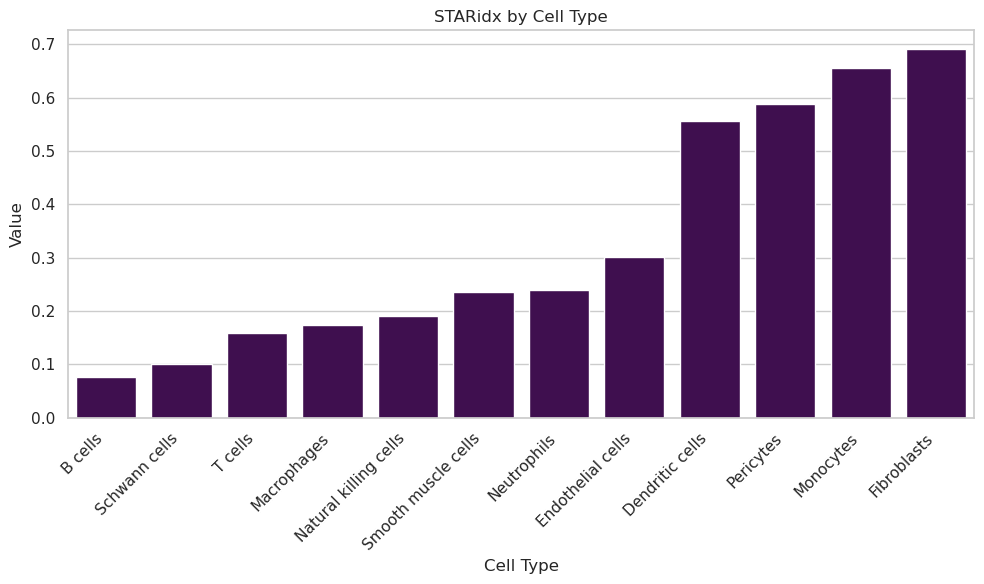

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt

# 设置图表风格
sns.set(style="whitegrid")

# 长格式数据
melted_data = NRI_with_CCRS.melt(id_vars="Cell Type", value_vars=["STARidx"], 
                                 var_name="Metric", value_name="Value")

custom_order = [
    'B cells', 'Schwann cells', 'T cells', 'Macrophages', 'Natural killing cells',
    'Smooth muscle cells','Neutrophils', 'Endothelial cells', 'Dendritic cells','Pericytes',
     'Monocytes', 'Fibroblasts'
]

# 绘制条形图
plt.figure(figsize=(10, 6))
sns.barplot(x="Cell Type", y="Value", data=melted_data, color="#44045A", order=custom_order)

# 图形美化
plt.title("STARidx by Cell Type")
plt.xticks(rotation=45, ha='right')  # 旋转 x 轴标签
plt.tight_layout()
plt.savefig("figures/STARidx by Cell Type.pdf", format='pdf')
plt.show()

In [80]:
import pandas as pd

# 假设 NRI_with_CCRS 是你提供的 DataFrame
df = NRI_with_CCRS[['Cell Type', 'NRI', 'CCRS_sum', 'STARidx']].copy()
df.set_index('Cell Type', inplace=True)


In [81]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), 
                         columns=df.columns, 
                         index=df.index)


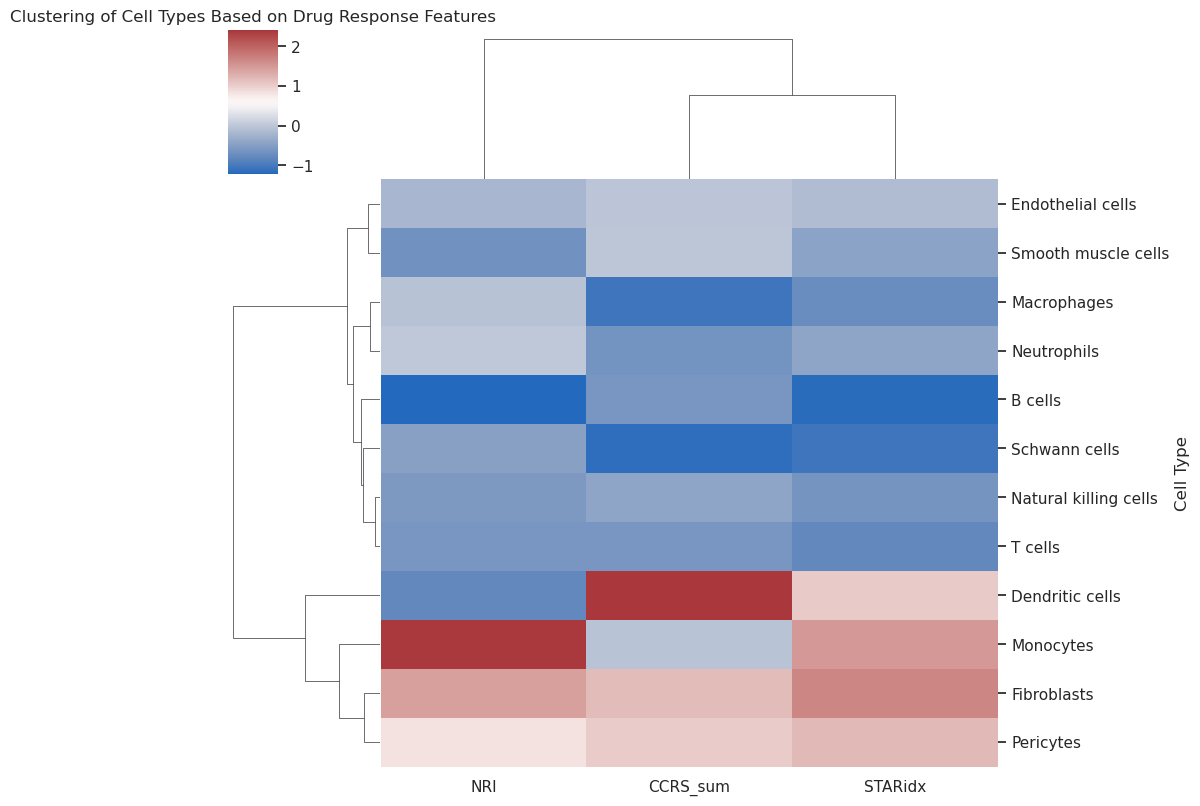

In [82]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.clustermap(df_scaled, 
               method='ward',       # 或 'average', 'complete'
               metric='euclidean',  # 或 'correlation'
               cmap='vlag', 
               figsize=(10, 8))
plt.title("Clustering of Cell Types Based on Drug Response Features")
plt.savefig("celltype_clustering_STARidx.pdf")
plt.show()


In [83]:
# 对每个细胞类型 - 基因，计算 ligand 参与的 CCRS 平均值
ligand_ccrs = merged_results.groupby(["source", "ligand"])["CCRS_ABg1g2"].mean().reset_index()
ligand_ccrs.columns = ["Cell Type", "Gene", "CCRS_mean"]

# 同理，receptor：
receptor_ccrs = merged_results.groupby(["target", "receptor"])["CCRS_ABg1g2"].mean().reset_index()
receptor_ccrs.columns = ["Cell Type", "Gene", "CCRS_mean"]

# 合并 ligand 和 receptor 数据
ccrs_gene_df = pd.concat([ligand_ccrs, receptor_ccrs], ignore_index=True)

# 同一个细胞类型 - 基因组合可能在 ligand 和 receptor 中都出现，进一步求均值
ccrs_gene_df = ccrs_gene_df.groupby(["Cell Type", "Gene"])["CCRS_mean"].mean().reset_index()


In [84]:
print(ccrs_gene_df.head())

  Cell Type     Gene  CCRS_mean
0   B cells    Abca1        0.0
1   B cells      Adm        0.0
2   B cells    Alcam        0.0
3   B cells  Angptl1        0.0
4   B cells     Apoo        0.0


/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


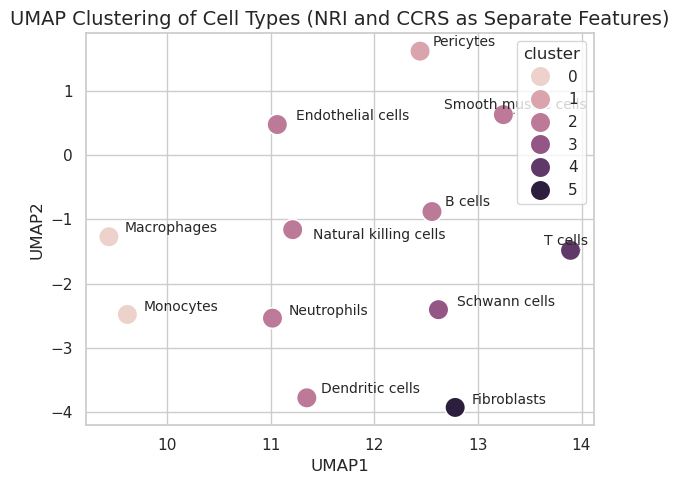

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import umap

RR_with_CCRS = RR_all.merge(ccrs_gene_df, on=["Cell Type", "Gene"], how="left")
RR_with_CCRS["CCRS_mean"] = RR_with_CCRS["CCRS_mean"].fillna(0)  # 没出现在CCI中的就设为0
# 2. 创建宽表：每个 Cell Type 是一行，每个 Gene 的 NRI / CCRS 是独立列
#    列名格式：Gene_NRI，Gene_CCRS
long_nri = RR_with_CCRS.pivot_table(index="Cell Type", columns="Gene", values="RR_all", fill_value=0)
long_ccrs = RR_with_CCRS.pivot_table(index="Cell Type", columns="Gene", values="CCRS_mean", fill_value=0)
# 重命名列区分特征
long_nri.columns = [f"{gene}_RR_all" for gene in long_nri.columns]
long_ccrs.columns = [f"{gene}_CCRS" for gene in long_ccrs.columns]
# 拼接成一个特征矩阵
matrix = pd.concat([long_nri, long_ccrs], axis=1)

# 3. 标准化
scaler = StandardScaler()
matrix_scaled = scaler.fit_transform(matrix)

# 4. 聚类
kmeans = KMeans(n_clusters=6, random_state=42)
cluster_labels = kmeans.fit_predict(matrix_scaled)
matrix["cluster"] = kmeans.fit_predict(matrix_scaled)

# 5. UMAP 降维
reducer = umap.UMAP(n_neighbors= 6, random_state=42, spread=2.0, min_dist=0.2)  # spread 控制整体拉开，min_dist 控制局部分布
umap_result = reducer.fit_transform(matrix_scaled)
matrix["UMAP1"] = umap_result[:, 0]
matrix["UMAP2"] = umap_result[:, 1]

# 6. 可视化
plt.figure(figsize=(6, 5))
sns.set(style="whitegrid")
texts = []
sns.scatterplot(data=matrix, x="UMAP1", y="UMAP2", hue="cluster", s=220)

for i in range(matrix.shape[0]):
    texts.append(
        plt.text(matrix.iloc[i]["UMAP1"] + 0.1, 
                 matrix.iloc[i]["UMAP2"], 
                 matrix.index[i], fontsize=10)
    )
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.title("UMAP Clustering of Cell Types (NRI and CCRS as Separate Features)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/UMAP_clustering_NRI_CCRS_split_features.pdf")
plt.show()

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


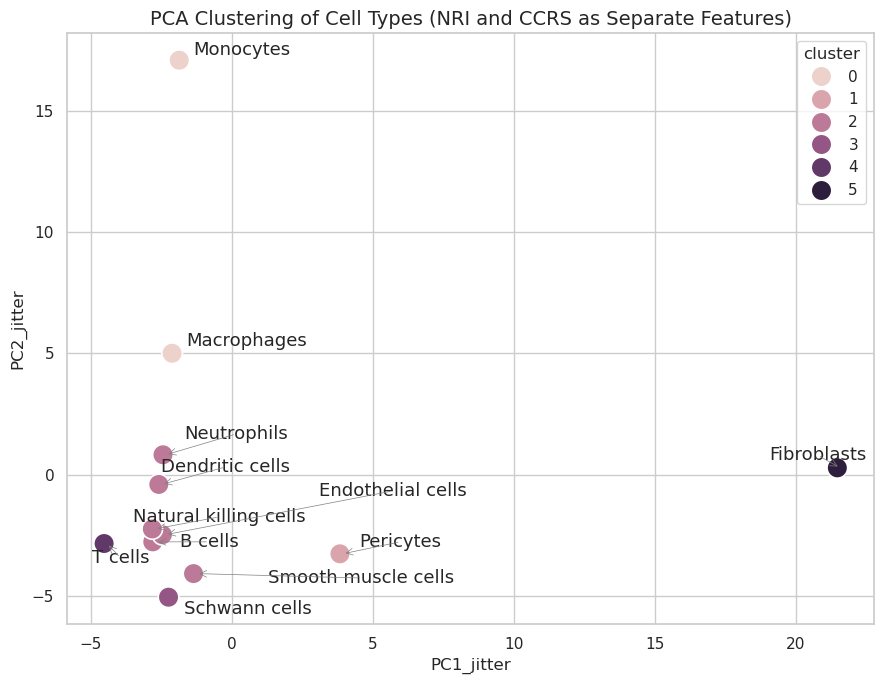

In [86]:
# 5. PCA 降维
pca = PCA(n_components=2)
pca_result = pca.fit_transform(matrix_scaled)
matrix["PC1"] = pca_result[:, 0]
matrix["PC2"] = pca_result[:, 1]

# 设置随机种子确保可重复
np.random.seed(42)
# 添加 jitter，使点略微分散，便于标注
jitter_strength = 1.5  # 可根据情况微调
matrix["PC1_jitter"] = matrix["PC1"] * 1
matrix["PC2_jitter"] = matrix["PC2"] * 1

# 6. 可视化
plt.figure(figsize=(9, 7))
sns.set(style="whitegrid")
texts = []
sns.scatterplot(data=matrix, x="PC1_jitter", y="PC2_jitter", hue="cluster", s=220)

for i in range(matrix.shape[0]):
    texts.append(
        plt.text(matrix.iloc[i]["PC1_jitter"] + 0.1, 
                 matrix.iloc[i]["PC2_jitter"], 
                 matrix.index[i], fontsize=13)
    )
# 调整文本（自动避开点）
adjust_text(texts, 
            only_move={'points':'y', 'text':'xy'},  # 允许文字移动方向
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.5),
            expand_points=(1.2, 1.4),  # 与点之间的距离
            expand_text=(1.2, 1.4),
            force_text=0.5,
            force_points=0.2
)

plt.title("PCA Clustering of Cell Types (NRI and CCRS as Separate Features)", fontsize=14)
plt.tight_layout()
#plt.savefig("figures/PCA_clustering_NRI_CCRS_split_features.pdf")
plt.show()

/slurm/home/yrd/fanlab/gaomeng/anaconda3/envs/env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.


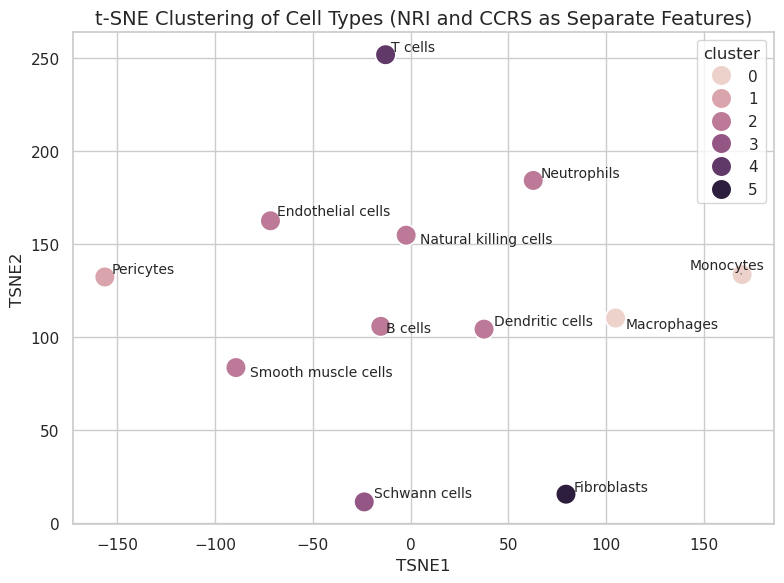

In [87]:
from sklearn.manifold import TSNE

# 5. t-SNE 降维
tsne = TSNE(
    n_components=2,
    perplexity=5,         # 稍微扩大邻域，减少过度分散
    learning_rate=300,     # 提高点移动速度
    n_iter=1500,           # 增加迭代次数更稳定
    early_exaggeration=8,  # 降低 exaggeration 使得不拉得太远
    init='pca',
    random_state=42
)

tsne_result = tsne.fit_transform(matrix_scaled)
matrix["TSNE1"] = tsne_result[:, 0]
matrix["TSNE2"] = tsne_result[:, 1]

# 6. 可视化 t-SNE 结果
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
texts = []
sns.scatterplot(data=matrix, x="TSNE1", y="TSNE2", hue="cluster", s=220)

for i in range(matrix.shape[0]):
    texts.append(
        plt.text(matrix.iloc[i]["TSNE1"] + 0.1, 
                 matrix.iloc[i]["TSNE2"], 
                 matrix.index[i], fontsize=10)
    )
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

plt.title("t-SNE Clustering of Cell Types (NRI and CCRS as Separate Features)", fontsize=14)
plt.tight_layout()
plt.savefig("figures/tSNE_clustering_NRI_CCRS_split_features.pdf")
plt.show()

In [88]:
# 筛选出 EoR_all > 0.5 的基因
ERGs_df = RR_all[RR_all["EoR_all"]>0.5][["Cell Type", "Gene", "EoR_all", "RR_all"]]
 
# 查看结果
print(ERGs_df)


       Cell Type      Gene   EoR_all     RR_all
4      Pericytes    Hspa1b  0.515683   8.250923
6      Pericytes   Adamts4  0.502298   5.022980
10     Pericytes    Pdgfrb  0.739917  16.278179
19     Pericytes    Cxcl10  0.586165  11.723292
22     Pericytes     Icam2  0.786134   1.572268
..           ...       ...       ...        ...
547  Fibroblasts     Aldoa  0.999387   0.999387
548  Fibroblasts     Hmgb2  0.742772   0.742772
549  Fibroblasts    Itgbl1  0.593410   3.560463
552  Fibroblasts  Marcksl1  0.957614   0.957614
553  Fibroblasts     Sept7  1.000000   1.000000

[205 rows x 4 columns]


In [89]:
#通路富集  cluster2
# 1. 获取 cluster 2 中的细胞类型
cluster2_cells = matrix[matrix["cluster"] == 5].index.tolist()

# 2. 在 RR_with_CCRS 中筛选这些细胞类型对应的 Gene
subset = ERGs_df[ERGs_df["Cell Type"].isin(cluster2_cells)]

# 3. 统计每个基因出现在哪些细胞类型中
gene_counts = subset.groupby("Gene")["Cell Type"].nunique()

# 4. 设置一个出现的“最少细胞类型数”阈值（例如超过一半）
min_required = int(len(cluster2_cells) * 0.1)

# 5. 筛选满足条件的基因
selected_genes = gene_counts[gene_counts >= min_required].index.tolist()

# 6. 查看满足条件的基因数
print(f"Cluster 2 中超过一半细胞类型中共有的基因数量为：{len(selected_genes)}")

# 7. 可用于富集分析的基因列表
print(selected_genes)

Cluster 2 中超过一半细胞类型中共有的基因数量为：19
['Aldoa', 'Atp6v0c', 'Clec3b', 'Col5a3', 'Cygb', 'Fbln2', 'Fstl1', 'Ftl1', 'H3f3a', 'Hmgb2', 'Itgbl1', 'Lama2', 'Marcksl1', 'Myl9', 'Ptn', 'Rgs5', 'Sept7', 'Srgn', 'Ubb']


In [90]:
# 筛选 Cell Type 为 Pericytes 的行
selected_df = ERGs_df[ERGs_df['Cell Type'] == 'Pericytes']

# 只取基因列，用于通路富集
selected = selected_df['Gene'].tolist()
print(f"基因数量为：{len(selected)}")
print(selected)

基因数量为：25
['Hspa1b', 'Adamts4', 'Pdgfrb', 'Cxcl10', 'Icam2', 'Fstl1', 'Col4a4', 'Lama2', 'Slc9a3r2', 'Ubb', 'Igfbp5', 'Sept4', 'Sept7', 'Ftl1', 'H3f3a', 'Myl9', 'Atp6v0c', 'Rgs5', 'Des', 'Aldoa', 'Hmgb2', 'Ugdh', 'Uap1', 'Cyp7b1', 'Marcksl1']


In [105]:
import gseapy as gp
import pandas as pd
# 你的 selected_genes 列表
gene_list = selected

# 运行富集分析（以 GO Biological Process 为例）
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Mouse',  # 如果是人类数据请改为 'Human'
                 outdir=None,  # 不输出到文件
                 cutoff=0.05  # 只看显著结果
                )

# 查看结果
results = enr.results
# 删除包含这些关键词的 term（不太相关）
remove_keywords = [
    "pancreatic", "glycan", "biosynthetic", "nucleotide", "telomere",
    "axon", "RNA", "DNA", "synapse", "methylation"
]
# 使用小写匹配剔除不相关的行
mask_remove = ~results["Term"].str.lower().str.contains('|'.join(remove_keywords))
filtered_results = results[mask_remove]
# 保留包含这些关键词的 term（和心梗机制相关）
keep_keywords = [
    "smooth muscle", "vascular", "leukocyte", "macrophage", "endothelial",
    "inflammatory", "extracellular matrix", "fibroblast", "chemotaxis",
    "apoptosis", "adhesion", "wound", "response to cytokine", "immune", 
    "inflammation", "migration", "proliferation", "cell cycle"
]
mask_keep = filtered_results["Term"].str.lower().str.contains('|'.join(keep_keywords))# 最终保留结果
final_results = filtered_results[mask_keep]

# 打印前10行
print(final_results[["Term", "Overlap", "Adjusted P-value", "P-value","Combined Score"]].head(10))

                                                 Term Overlap  \
3   positive regulation of smooth muscle cell migr...    2/17   
5   regulation of smooth muscle cell migration (GO...    2/20   
6      extracellular matrix organization (GO:0030198)   4/300   
11                 lymphocyte chemotaxis (GO:0048247)    2/44   
12  positive regulation of smooth muscle cell prol...    2/46   
13  regulation of smooth muscle cell proliferation...    2/49   
16                       cell chemotaxis (GO:0060326)    2/69   
20  regulation of endothelial tube morphogenesis (...     1/5   
28                     B cell chemotaxis (GO:0035754)     1/6   
37          smooth muscle cell migration (GO:0014909)     1/7   

    Adjusted P-value   P-value  Combined Score  
3           0.021832  0.000202      984.563309  
5           0.021832  0.000281      788.330757  
6           0.028139  0.000489       96.523539  
11          0.053361  0.001374      271.961682  
12          0.053808  0.001501      256

/tmp/ipykernel_97657/1901822915.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


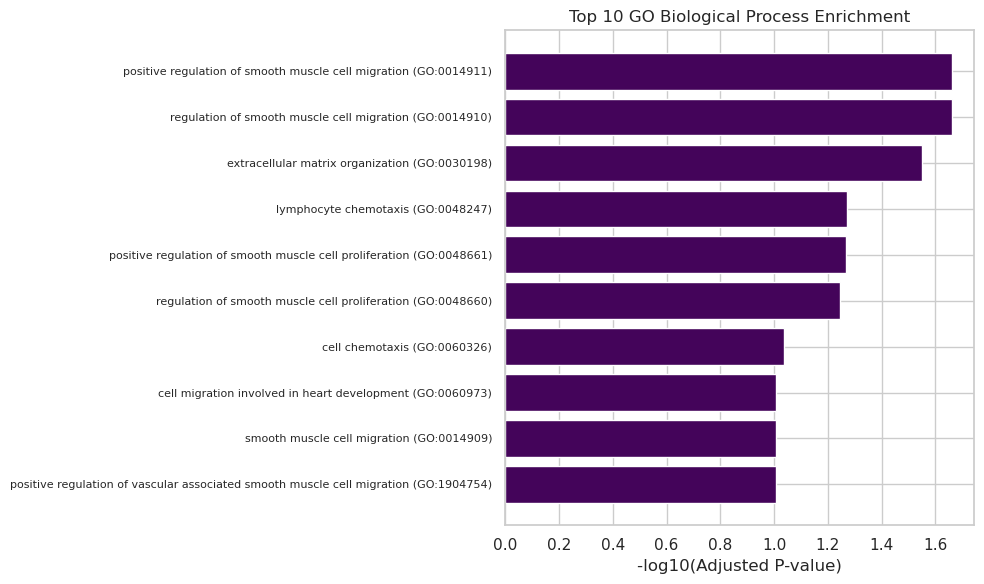

In [92]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

top_terms = final_results.sort_values("Adjusted P-value").head(10)
top_terms["minus_log10_padj"] = -np.log10(top_terms["Adjusted P-value"])

# 截断 -log10(padj)，避免极端大值导致颜色差距过大
max_clip = np.percentile(top_terms["minus_log10_padj"], 80)  # 取90百分位作为上限
clipped_values = np.clip(top_terms["minus_log10_padj"], None, max_clip)

# 伽马校正参数，>1表示压缩高值，<1表示强化高值
gamma = 1  
normalized = (clipped_values - clipped_values.min()) / (clipped_values.max() - clipped_values.min())
adjusted = normalized ** gamma  # 伽马调整

cmap = cm.get_cmap("viridis_r")
colors = cmap(adjusted)

plt.figure(figsize=(10,6))
plt.barh(top_terms["Term"], top_terms["minus_log10_padj"], color="#44045A")
plt.xlabel('-log10(Adjusted P-value)')
plt.title('Top 10 GO Biological Process Enrichment')
plt.gca().invert_yaxis()
plt.yticks(fontsize=8)  # y轴标签字体大小

plt.tight_layout()
plt.savefig('/slurm/home/yrd/fanlab/gaomeng/NRI/1/figures/enrichment_Pericyte2.pdf', format='pdf',backend="cairo")
plt.show()


In [93]:
print(top_terms["Term"])


3     positive regulation of smooth muscle cell migr...
5     regulation of smooth muscle cell migration (GO...
6        extracellular matrix organization (GO:0030198)
11                   lymphocyte chemotaxis (GO:0048247)
12    positive regulation of smooth muscle cell prol...
13    regulation of smooth muscle cell proliferation...
16                         cell chemotaxis (GO:0060326)
43    cell migration involved in heart development (...
37            smooth muscle cell migration (GO:0014909)
46    positive regulation of vascular associated smo...
Name: Term, dtype: object


In [94]:
#通路富集  cluster2
# 1. 获取 cluster 5 中的细胞类型
cluster2_cells = matrix[matrix["cluster"] == 5].index.tolist()

# 2. 在 RR_with_CCRS 中筛选这些细胞类型对应的 Gene
subset = ERGs_df[ERGs_df["Cell Type"].isin(cluster2_cells)]

# 3. 统计每个基因出现在哪些细胞类型中
gene_counts = subset.groupby("Gene")["Cell Type"].nunique()

# 4. 设置一个出现的“最少细胞类型数”阈值（例如超过一半）
min_required = int(len(cluster2_cells) * 0.5)

# 5. 筛选满足条件的基因
f_genes = gene_counts[gene_counts >= min_required].index.tolist()

# 6. 查看满足条件的基因数
print(f"Cluster 5 中超过一半细胞类型中共有的基因数量为：{len(f_genes)}")

# 7. 可用于富集分析的基因列表
print(f_genes)

Cluster 5 中超过一半细胞类型中共有的基因数量为：19
['Aldoa', 'Atp6v0c', 'Clec3b', 'Col5a3', 'Cygb', 'Fbln2', 'Fstl1', 'Ftl1', 'H3f3a', 'Hmgb2', 'Itgbl1', 'Lama2', 'Marcksl1', 'Myl9', 'Ptn', 'Rgs5', 'Sept7', 'Srgn', 'Ubb']


In [95]:
# 你的 selected_genes 列表
gene_list = f_genes

# 运行富集分析（以 GO Biological Process 为例）
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Biological_Process_2021',
                            'Reactome_2022',
                            'GO_Biological_Process_2023'
                           ],
                 organism='Mouse',  # 如果是人类数据请改为 'Human'
                 outdir=None,  # 不输出到文件
                 cutoff=0.05  # 只看显著结果
                )

# 查看结果
results = enr.results
# 删除包含这些关键词的 term（不太相关）
remove_keywords = [
    "pancreatic", "glycan", "biosynthetic", "nucleotide", "telomere",
    "axon", "RNA", "DNA", "synapse", "methylation"
]
# 使用小写匹配剔除不相关的行
mask_remove = ~results["Term"].str.lower().str.contains('|'.join(remove_keywords))
filtered_results = results[mask_remove]
# 保留包含这些关键词的 term（和心梗机制相关）
keep_keywords = [
    "fibroblast", "extracellular matrix", "collagen", "fibrosis", "wound healing",
    "myofibroblast", "matrix remodeling", "fibroblast proliferation", "tgf-beta",
    "adhesion", "response to cytokine", "inflammatory", "chemotaxis", "apoptosis", "fiber"
]
mask_keep = filtered_results["Term"].str.lower().str.contains('|'.join(keep_keywords))# 最终保留结果
final_results = filtered_results[mask_keep]

# 打印前10行
print(final_results[["Term", "Overlap", "Adjusted P-value", "Combined Score"]].head(10))

                                                  Term Overlap  \
1       supramolecular fiber organization (GO:0097435)   4/351   
13   leukocyte chemotaxis involved in inflammatory ...     1/6   
63     regulation of leukocyte chemotaxis (GO:0002688)    1/19   
110     extracellular matrix organization (GO:0030198)   2/300   
139  regulation of cell-substrate adhesion (GO:0010...    1/43   
142          homotypic cell-cell adhesion (GO:0034109)    1/44   
143     positive regulation of chemotaxis (GO:0050921)    1/45   
155  positive regulation of leukocyte chemotaxis (G...    1/54   
172                       cell chemotaxis (GO:0060326)    1/69   
173  positive regulation of cell-substrate adhesion...    1/70   

     Adjusted P-value  Combined Score  
1            0.044742      122.730625  
13           0.070384     1147.410799  
63           0.081713      247.856157  
110          0.084552       26.646195  
139          0.086712       84.838696  
142          0.087449       82.28

In [96]:
print(merged_results[["source","target","ligand", "receptor", "BC_AB_g1g2","CCRS_ABg1g2"]].head())


        source                 target  ligand receptor  BC_AB_g1g2  \
0  Neutrophils                T cells  S100a8     Cd69    0.000000   
1  Neutrophils              Monocytes  S100a8     Cd68    0.000000   
2  Neutrophils                B cells  S100a8     Cd69    0.000000   
3  Neutrophils            Macrophages  S100a8     Cd68    0.000000   
4  Neutrophils  Natural killing cells  S100a8     Cd69    0.005538   

   CCRS_ABg1g2  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.005538  


In [97]:
filtered__df = merged_results[merged_results["BC_AB_g1g2"] != 0]

# 去重得到唯一配受体对
unique_lr_pairs = filtered__df[["ligand", "receptor",'source','target']].drop_duplicates().reset_index(drop=True)
# 1. 计算 Ir（平均值）
merged_results["Ir"] = merged_results[["lr_means_smi", "lr_means_model", "lr_means"]].mean(axis=1)

# 2. 取配对与细胞类型四元组 + Ir（防止重复）
lr_with_ir = merged_results[["ligand", "receptor", "source", "target", "Ir"]].drop_duplicates()

# 3. 合并进 unique_lr_pairs（按 ligand, receptor, source, target 匹配）
unique_lr_pairs = pd.merge(unique_lr_pairs, lr_with_ir, on=["ligand", "receptor", "source", "target"], how="left")

# 4. 查看结果
print(unique_lr_pairs.head())
print(f"filtered_df 中共有 {unique_lr_pairs.shape[0]} 个唯一的配受体对（不考虑细胞类型）")


   ligand receptor                 source                 target        Ir
0  S100a8     Cd69            Neutrophils  Natural killing cells  2.788913
1    Ccl5     Ccr1  Natural killing cells            Neutrophils  2.700622
2    Myl9     Cd69    Smooth muscle cells  Natural killing cells  2.472067
3  S100a8    Itgb2            Neutrophils  Natural killing cells  2.159142
4    Ccl5     Ccr5  Natural killing cells                T cells  2.209754
filtered_df 中共有 414 个唯一的配受体对（不考虑细胞类型）


In [98]:
# 读取原始节点信息
nodes_df = pd.read_csv('PPI_merged_for_Cytoscape/nodes.tsv', sep='\t')

# 2. 从 filtered__df 提取 ligand → source，receptor → target
ligands = filtered__df[['ligand', 'source']].rename(columns={'ligand': 'gene', 'source': 'cell_type'})
receptors = filtered__df[['receptor', 'target']].rename(columns={'receptor': 'gene', 'target': 'cell_type'})

# 3. 合并所有的 gene-cell_type 对
ligrec = pd.concat([ligands, receptors], ignore_index=True)

# 4. 聚合细胞类型信息，格式为 "Astrocyte;Endothelial"
gene2ct = ligrec.groupby('gene')['cell_type'].apply(lambda x: ';'.join(sorted(set(x)))).reset_index()
gene2ct = gene2ct.rename(columns={'cell_type': 'cell_types'})  # ✅ 关键！
# 5. 仅选出不在 nodes.tsv 中的基因
existing_genes = set(nodes_df['gene'])
new_genes_df = gene2ct[~gene2ct['gene'].isin(existing_genes)].copy()

# 6. 填充缺失字段（用 None 占位），保持列对齐
for col in nodes_df.columns:
    if col not in new_genes_df.columns:
        new_genes_df[col] = None

# 7. 调整列顺序以匹配原表
new_genes_df = new_genes_df[nodes_df.columns]

# 8. 合并并导出结果
final_nodes = pd.concat([nodes_df, new_genes_df], ignore_index=True)
final_nodes.to_csv('PPI_merged_for_Cytoscape/nodes_with_LR.tsv', sep='\t', index=False)

/tmp/ipykernel_97657/3316232174.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [99]:
import pandas as pd

# Step 1: 读取 Cytoscape 边表
edges_df = pd.read_csv("PPI_merged_for_Cytoscape/edges.tsv", sep="\t")

# 转换为大写后构造无向键
unique_lr_pairs["ligand_upper"] = unique_lr_pairs["ligand"].str.upper()
unique_lr_pairs["receptor_upper"] = unique_lr_pairs["receptor"].str.upper()
unique_lr_pairs["lr_pair"] = unique_lr_pairs.apply(
    lambda row: tuple(sorted([row["ligand_upper"], row["receptor_upper"]])), axis=1
)

# 计算每对配受体的 Ir 平均值（不区分细胞类型）
ir_means = unique_lr_pairs.groupby("lr_pair")["Ir"].mean().reset_index()
ir_means.columns = ["lr_pair", "Ir_mean"]
lr_set = set(ir_means["lr_pair"])

# Step 3: 对 edges 中的 gene 名统一大写并构造无向 edge key
edges_df["source_upper"] = edges_df["source"].str.upper()
edges_df["target_upper"] = edges_df["target"].str.upper()
edges_df["edge_pair"] = edges_df.apply(
    lambda row: tuple(sorted([row["source_upper"], row["target_upper"]])),
    axis=1
)

# Step 4: 标记已有的 LR 边
edges_df["is_LR"] = edges_df["edge_pair"].isin(lr_set)
edges_df["Edge_type"] = edges_df["is_LR"].map({True: "Ligand-Receptor", False: "PPI"})

# Step 5: 构造缺失的 LR 对应的边（即不在 edges 中的配受体对）
existing_edges = set(edges_df["edge_pair"])
missing_pairs = lr_set - existing_edges

# 构建新的 DataFrame
missing_edges = pd.DataFrame(
    list(missing_pairs), columns=["source", "target"]
)
missing_edges["is_LR"] = True
missing_edges["Edge_type"] = "Ligand-Receptor"
missing_edges["edge_pair"] = missing_edges.apply(
    lambda row: tuple(sorted([row["source"].upper(), row["target"].upper()])), axis=1
)

# Step 6: 合并原始 edges 与新添加的 missing LR 边
combined_edges = pd.concat([
    edges_df,
    missing_edges
], ignore_index=True)

# Step 7: 合并 Ir_mean
final_edges = pd.merge(
    combined_edges,
    ir_means,
    how="left",
    left_on="edge_pair",
    right_on="lr_pair"
).drop(columns=["source_upper", "target_upper", "lr_pair", "edge_pair"])

# Step 8: 保存最终 edges 表
final_edges.to_csv("PPI_merged_for_Cytoscape/edges_3.tsv", sep="\t", index=False)

print(f"✅ edges_3.tsv 已生成，配受体对总数：{len(lr_set)}，其中新增 {len(missing_pairs)} 条边。已为配受体边添加 Ir 平均值。")


✅ edges_3.tsv 已生成，配受体对总数：138，其中新增 124 条边。已为配受体边添加 Ir 平均值。


In [100]:
import pandas as pd

# Step 1: 读取 Cytoscape 边表
edges_df = pd.read_csv("PPI_merged_for_Cytoscape/edges.tsv", sep="\t")

# Step 2: 构造 unique_lr_pairs 的无向集合（大写）
lr_set = set(
    tuple(sorted([lig.upper(), rec.upper()]))
    for lig, rec in zip(unique_lr_pairs["ligand"], unique_lr_pairs["receptor"])
)

# Step 3: 对 edges 中的 gene 名统一大写并构造无向 edge key
edges_df["source_upper"] = edges_df["source"].str.upper()
edges_df["target_upper"] = edges_df["target"].str.upper()
edges_df["edge_pair"] = edges_df.apply(
    lambda row: tuple(sorted([row["source_upper"], row["target_upper"]])),
    axis=1
)

# Step 4: 标记配受体边
edges_df["is_LR"] = edges_df["edge_pair"].isin(lr_set)
edges_df["Edge_type"] = edges_df["is_LR"].map({True: "Ligand-Receptor", False: "PPI"})

# Step 5: 清理临时列
edges_df.drop(columns=["source_upper", "target_upper", "edge_pair"], inplace=True)

# Step 6: 保存新的 edges 表
edges_df.to_csv("PPI_merged_for_Cytoscape/edges_2.tsv", sep="\t", index=False)

print(f"✅ 已将 {len(lr_set)} 个配受体对映射到 edges_2.tsv，Cytoscape 中可使用 Edge_type 进行着色。")


✅ 已将 138 个配受体对映射到 edges_2.tsv，Cytoscape 中可使用 Edge_type 进行着色。


In [101]:
n_matched = edges_df["is_LR"].sum()
print(f"✅ 成功匹配到 {n_matched} 条配受体边")
print(edges_df[edges_df["is_LR"]].head(20))

✅ 成功匹配到 14 条配受体边
      source target  score  is_LR        Edge_type
412    Plaur    Fn1  0.768   True  Ligand-Receptor
832   S100a4   Egfr  0.638   True  Ligand-Receptor
900     Sdc4    Ptn  0.566   True  Ligand-Receptor
906     Sdc4    Tnc  0.950   True  Ligand-Receptor
907     Sdc4  Thbs1  0.977   True  Ligand-Receptor
958     Egfr    Dcn  0.995   True  Ligand-Receptor
1394    Ccl2   Ccr1  0.998   True  Ligand-Receptor
1476    Csf1  Csf3r  0.654   True  Ligand-Receptor
2179   Itgb2   Cd14  0.771   True  Ligand-Receptor
2436    Mrc1  Ptprc  0.824   True  Ligand-Receptor
2496    Tlr2    Dcn  0.986   True  Ligand-Receptor
2497    Tlr2    Bgn  0.992   True  Ligand-Receptor
2502   Abca1   Pltp  0.828   True  Ligand-Receptor
2515     Pf4   Thbd  0.711   True  Ligand-Receptor


In [102]:
#无向匹配得到与【is_LR】配受体对的source 基因相关的配受体有哪些
# Step 0: 清理列名
merged_results.columns = merged_results.columns.str.strip()

# Step 1: 提取 edges_df 中 is_LR 为 True 的 source 基因列表
source_genes = edges_df[edges_df["is_LR"]]["source"].unique()

# Step 2: 在 BC_results 中找所有 ligand 或 receptor 与这些 source 基因重合的行（无向匹配）
matched_rows = merged_results[
    merged_results["ligand"].isin(source_genes) | merged_results["receptor"].isin(source_genes)
]

# Step 3: 选出想保留的字段（可按需扩展）
matched_df = matched_rows[["ligand", "receptor", "RLAB_g1g2"]].copy()

# Step 4: 去重（如有重复）
matched_df = matched_df.drop_duplicates().reset_index(drop=True)

# Step 5: 打印检查
# 按 RLAB_g1g2 从大到小排序并打印前 20 行
#print(matched_df.sort_values(by="RLAB_g1g2", ascending=False).head())
print(f"✅ 共找到 {matched_df.shape[0]} 条与 source 基因相关的配受体对")

lr_mean_df = (
    matched_df
    .groupby(["ligand", "receptor"], as_index=False)
    .agg({"RLAB_g1g2": "mean"})
    .sort_values("RLAB_g1g2", ascending=False)  # 可选：按大小排序
)

# 显示前几行结果
print(lr_mean_df.head(20))
print(f"共得到 {lr_mean_df.shape[0]} 个唯一的 ligand-receptor 对（已求平均）")

✅ 共找到 984 条与 source 基因相关的配受体对
     ligand receptor   RLAB_g1g2
13   Cxcl10     Sdc4  164.231873
40    Thbs1     Sdc4   13.307507
34   S100a4     Ccr5    1.276207
23    L1cam     Egfr    1.093482
35   S100a4     Egfr    0.895483
25     Mrc1    Ptprc    0.741612
28      Pf4    Procr    0.709104
36   S100a4    Erbb3    0.706707
2     Anxa1     Egfr    0.660542
31     Pltp    Abca1    0.658036
45    Vegfa     Egfr    0.638943
8      Ccl5     Sdc4    0.628863
38   Selplg    Itgb2    0.613504
18     Fgf1     Egfr    0.576064
24    Lrig1     Egfr    0.569347
26     Nrg4     Egfr    0.553688
16      Dcn     Tlr2    0.540608
10  Ceacam1     Egfr    0.524124
17   Efemp1     Egfr    0.507778
15      Dcn     Egfr    0.501622
共得到 47 个唯一的 ligand-receptor 对（已求平均）


In [103]:
#在PPI中直接连接的配受体的回调水平
# Step 1: 清理列名
lr_mean_df.columns = lr_mean_df.columns.str.strip()

# Step 2: 筛选出 is_LR 为 True 的边
lr_edges = edges_df[edges_df["is_LR"]].copy()

# Step 3: 构造无向匹配键：将 (source, target) 和 (ligand, receptor) 排序后拼接
def make_key(a, b):
    return tuple(sorted([a, b]))

# 为 edges_df 添加 key
lr_edges["pair_key"] = lr_edges.apply(lambda row: make_key(row["source"], row["target"]), axis=1)

# 为 lr_mean_df 添加 key
lr_mean_df["pair_key"] = lr_mean_df.apply(lambda row: make_key(row["ligand"], row["receptor"]), axis=1)

# Step 4: 合并（基于 pair_key）
merged_df = pd.merge(
    lr_edges,
    lr_mean_df[["pair_key", "RLAB_g1g2"]],
    on="pair_key",
    how="left"
)

# Step 5: 取出最终结果（只保留原始 source, target 和匹配到的 RLAB_g1g2）
key_pairs_df = merged_df[["source", "target", "RLAB_g1g2"]].copy()
key_pairs_df.rename(columns={"RLAB_g1g2": "RLAB_g1g2"}, inplace=True)

# 打印确认
print(key_pairs_df.head(10))
print(f"✅ 匹配到 RLAB_g1g2 的配受体对数量: {key_pairs_df['RLAB_g1g2'].notna().sum()}")

   source target  RLAB_g1g2
0   Plaur    Fn1  -2.262172
1  S100a4   Egfr   0.895483
2    Sdc4    Ptn   0.107669
3    Sdc4    Tnc  -0.074114
4    Sdc4  Thbs1  13.307507
5    Egfr    Dcn   0.501622
6    Ccl2   Ccr1   0.322682
7    Csf1  Csf3r  -1.231276
8   Itgb2   Cd14  -0.250313
9    Mrc1  Ptprc   0.741612
✅ 匹配到 RLAB_g1g2 的配受体对数量: 14


In [104]:
ccl2_df = lr_mean_df[(lr_mean_df["ligand"] == "Egfr") | (lr_mean_df["receptor"] == "Egfr")].copy()
print(ccl2_df.head(10))
# 构造用于弦图的DataFrame
chord_df = pd.DataFrame({
    "source": ccl2_df["ligand"],
    "target": ccl2_df["receptor"],
    "value": ccl2_df["RLAB_g1g2"]
})

# 保存为csv文件
chord_df.to_csv("/slurm/home/yrd/fanlab/gaomeng/NRI/1/Egfr_chord_data.csv", index=False)

     ligand receptor  RLAB_g1g2         pair_key
23    L1cam     Egfr   1.093482    (Egfr, L1cam)
35   S100a4     Egfr   0.895483   (Egfr, S100a4)
2     Anxa1     Egfr   0.660542    (Anxa1, Egfr)
45    Vegfa     Egfr   0.638943    (Egfr, Vegfa)
18     Fgf1     Egfr   0.576064     (Egfr, Fgf1)
24    Lrig1     Egfr   0.569347    (Egfr, Lrig1)
26     Nrg4     Egfr   0.553688     (Egfr, Nrg4)
10  Ceacam1     Egfr   0.524124  (Ceacam1, Egfr)
17   Efemp1     Egfr   0.507778   (Efemp1, Egfr)
15      Dcn     Egfr   0.501622      (Dcn, Egfr)
